#### Useful imports and extensions

In [2]:
import jsonlines
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
import numpy as np
import json
import plotly.express as px
from plotly import graph_objects as go
from tqdm import tqdm
import statsmodels.formula.api as smf

from classify_google_utils import classify_all
from helpers import *

%load_ext autoreload

## Loading dataset and extracting climate change related videos

We want to study youtube videos related to climate change : the first step is to filter our broad dataset of all videos.
For this, we generated a list of keywords related to climate change :

In [3]:
with open('keywords.json') as f:
    keywords = json.load(f)['keywords']

for k in keywords:
    print(k)

climate change
global warming
greenhouse gases
rising sea levels
extreme weather
temperature increase
climate action
carbon emissions
renewable energy
sustainable living
climate science
climate crisis
climate adaptation
natural disaster
extreme heat
melting ice cap
sea level rise
biodiversity loss
deforestation
ocean acidification
climate policy
environmental policy
disaster recovery
climate refugees
carbon footprint
sustainable development
green technology
renewable resource
eco-friendly
ecosystem disruption
impact on climate
paris agreement
climate awareness
environmental justice
clean energy
zero carbon
green infrastructure
ozone layer
pollution
water scarcity
climate education


We create functions to check if a video contains climate change related keywords in its title, description or tags

In [ ]:
def about_climate(tags):
    tags_set = set(tags)
    return any(tag.strip().lower() in keywords for tag in tags_set)

def climate_text(text):
    lowercase_text = text.lower()
    return any(keyword in lowercase_text for keyword in keywords)

def climate_related(video):
    return (climate_text(video['title']) or about_climate(video['tags']) or climate_text(video['description']))

Since the original video metadata dataset is huge (97 GB), we read and filter the dataset using pyskark in order to get a reduced dataset with only the relevant videos.

### Load the dataset

In [ ]:
path_to_disk = '/Volumes/Maxtor'
file_path = '/yt_metadata_en.jsonl'

sc = SparkContext()
raw_data = sc.textFile(path_to_disk + file_path)
video_dataset = raw_data.map(lambda x: json.loads(x))

### Filter the dataset

In [ ]:
climate_videos = video_dataset.filter(climate_related)
climate_videos_collected = climate_videos.collect()

In [ ]:
climate_videos_path = "data/coarse_filter_climate_videos.jsonl"
with jsonlines.open(climate_videos_path, "w") as jsonl_file:
   jsonl_file.write_all(climate_videos_collected)

#### Sample dataset

We create 2 random sample dataset (1% ands 0.1%) which may be useful later in our analysis for statisitical comparison with the cliamte related videos dataset.

In [ ]:
seed = 42

random_sample_1percent = video_dataset.sample(False, 0.01, seed=seed)
random_sample_1percent_collected = random_sample_1percent.collect()
sample_1percent_path = "data/sample_1percent.jsonl"
with jsonlines.open(sample_1percent_path, "w") as jsonl_file:
    jsonl_file.write_all(random_sample_1percent_collected)


random_sample_01percent = video_dataset.sample(False, 0.001, seed=seed)
random_sample_01percent_collected = random_sample_01percent.collect()
sample_01percent_path = "data/sample_01percent.jsonl"
with jsonlines.open(sample_01percent_path, "w") as jsonl_file:
    jsonl_file.write_all(random_sample_01percent_collected)


In [ ]:
sc.stop()

### Extracting useful features from the whole dataset

We keep working on the whole dataset in order to extract useful features which may be useful later for comparison purpose. We use the .feather helper for this. 

In [ ]:
feather_path = "data/yt_metadata_helper.feather"
video_dataset_feather = pd.read_feather(feather_path)

In [ ]:
video_count_by_date_cat = video_dataset_feather.groupby(['upload_date', 'categories']).size().reset_index(name='count')
video_count_by_date_cat['upload_date'] = video_count_by_date_cat['upload_date'].dt.strftime('%Y-%m-%d')
video_count_by_date = video_count_by_date_cat[['upload_date', 'count']].groupby(['upload_date']).sum().reset_index()
video_count_by_cat = video_count_by_date_cat[['categories', 'count']].groupby(['categories']).sum().reset_index()
nb_videos = video_dataset_feather.shape[0]
print(f"Number of videos: {nb_videos}")

Number of videos: 72924794


In [ ]:
video_count_by_date_cat.to_json("data/nb_videos_by_date_cat.jsonl", orient="records", lines=True)
video_count_by_date.to_json("data/nb_videos_by_date.jsonl", orient="records", lines=True)
video_count_by_cat.to_json("data/nb_videos_by_cat.jsonl", orient="records", lines=True)

### Filtering refinment

In [ ]:
coarse_filter_climate_videos_path = "data/climate_videos.jsonl" 
coarse_filter_climate_videos = pd.read_json(coarse_filter_climate_videos_path, lines=True)
nb_coarse_climate_videos = coarse_filter_climate_videos.shape[0]
print(f"Number of climate related videos {nb_coarse_climate_videos}")

Number of climate related videos 145008


Even though we filtered out a lot of videos, we still observed several non climate related videos. Hence we have to perform a beter filtering. Having much less data allows us to use a much more costly but more accurate filtering method: using an NLP classifier. We use the google content classifier.

### Classifying videos using google content classifier

In [ ]:
google_credentials_path = "silent-circlet-407818-8bcb92199b3e.json"
classified_coarse_filter_climate_videos_df = classify_all(video_dataframe=coarse_filter_climate_videos, credentials_path=google_credentials_path)

In [ ]:
classified_path = "data/climate_videos_sample_classified.jsonl"
classified_coarse_filter_climate_videos_df.to_json(classified_path, orient="records", lines=True)

Now that we could give more categories to each videos, we will use these to filter out more videos

### Further filtering using the google classification
We do a second filtering to keep only videos that contain at least one climate-related category according to Google content classifier.

First we define the list of climate-related categories, and then we filter the dataframe with it.

In [ ]:
most_common_categories = classified_coarse_filter_climate_videos_df['classification_categories'].explode().unique()
# remove nan and non category values
most_common_categories = [category for category in most_common_categories 
                          if isinstance(category, str) and category.startswith('/')]

In [ ]:
climate_related_categories = []

# Filter categories with the keywords
for cat in most_common_categories:
    if any(keyword in cat for keyword in keywords):
        climate_related_categories.append(cat)

# Manualy remove non relevant ones
climate_related_categories.remove('/News/Business News/Economy News')
climate_related_categories.remove('/People & Society/Social Sciences/Economics')
climate_related_categories.remove('/Health/Health Conditions/Allergies/Environmental Allergies')

In [ ]:
climate_related_categories

['/People & Society/Social Issues & Advocacy/Green Living & Environmental Issues',
 '/Science/Ecology & Environment/Other',
 '/Science/Ecology & Environment/Climate Change & Global Warming',
 '/Business & Industrial/Energy & Utilities/Renewable & Alternative Energy',
 '/Shopping/Green & Eco-Friendly Shopping',
 '/Travel & Transportation/Specialty Travel/Ecotourism']

In [ ]:
df = classified_coarse_filter_climate_videos_df[classified_coarse_filter_climate_videos_df['classification_categories']
                                        .apply(lambda x: any(category in x.keys() for category in climate_related_categories))]

In [ ]:
df.to_json('climate_videos_v3.jsonl', orient='records', lines=True)

We finally export the double-filtered dataframe in a jsonl file:

In [ ]:
final_filter_climate_videos_path = "data/climate_videos_v3.jsonl"
climate_videos_df = pd.read_json(final_filter_climate_videos_path, lines=True)
nb_climate_videos = climate_videos_df.shape[0]

The filtering steps result in:

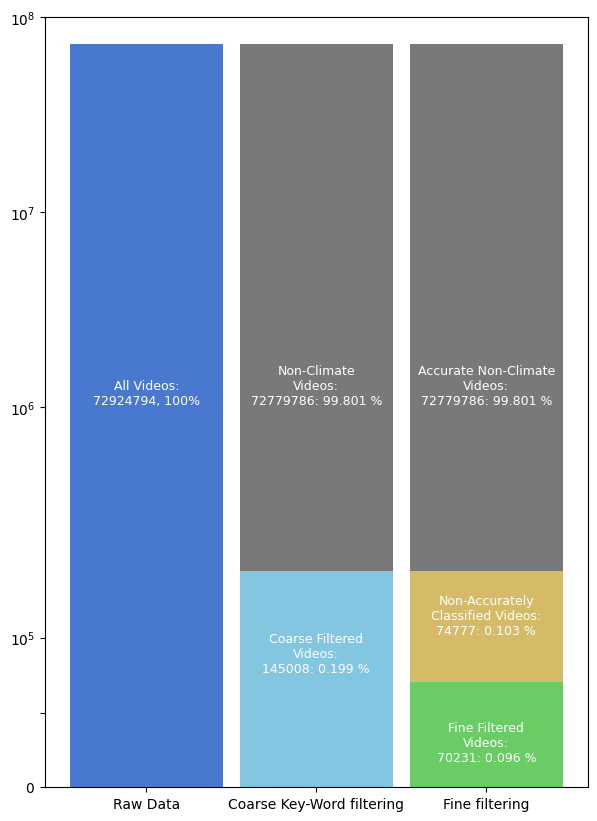

In [ ]:
STEPS = ('Raw Data', 'Coarse Key-Word filtering', 'Fine filtering')
COLORS = sns.color_palette("muted")
WIDTH = 0.9
FIG_SIZE = (7, 10)
FONT_SIZE = 9

nb_videos_plotting = nb_videos
non_climate_videos = nb_videos_plotting - nb_coarse_climate_videos
non_accurately_classified = nb_coarse_climate_videos - nb_climate_videos
accurate_non_climate_videos = nb_videos_plotting - nb_climate_videos - non_accurately_classified

weight_counts = {
    "Below": ([nb_videos_plotting, nb_coarse_climate_videos, nb_climate_videos], [COLORS[0], COLORS[9], COLORS[2]]),
    "Middle": ([0, non_climate_videos, non_accurately_classified], [COLORS[0], COLORS[7], COLORS[8]]),
    "Above": ([0, 0, accurate_non_climate_videos], [COLORS[0], COLORS[7], COLORS[7]])
}

# Plotting
fig, ax = plt.subplots(figsize=FIG_SIZE)
bottom = np.zeros(3)

for boolean, (weight_count, color) in weight_counts.items():
    ax.bar(STEPS, weight_count, WIDTH, label=boolean, bottom=bottom, color=color)
    bottom += weight_count


plt.yscale('symlog', linthresh=nb_coarse_climate_videos*1)
plt.yticks(ticks=list(range(0, nb_coarse_climate_videos, 50000)) + [10**i for i in range(6, 9)])

annotations = [
    (0, 1000000, f"All Videos:\n{nb_videos_plotting}, 100%"),
    (1, 75000, f"Coarse Filtered\nVideos:\n{nb_coarse_climate_videos}: {nb_coarse_climate_videos/nb_videos*100:.3f} %"),
    (2, 15000, f"Fine Filtered\nVideos:\n{nb_climate_videos}: {nb_climate_videos/nb_videos*100:.3f} %"),
    (1, 1000000, f"Non-Climate\nVideos:\n{non_climate_videos}: {non_climate_videos/nb_videos*100:.3f} %"),
    (2, 100000, f"Non-Accurately\nClassified Videos:\n{non_accurately_classified}: {non_accurately_classified/nb_videos*100:.3f} %"),
    (2, 1000000, f"Accurate Non-Climate\nVideos:\n{accurate_non_climate_videos}: {accurate_non_climate_videos/nb_videos*100:.3f} %")
]

for x, y, text in annotations:
    ax.text(x, y, text, ha='center', va='bottom', color='white', fontsize=FONT_SIZE)

plt.show()

In [ ]:
zoom = 500000
x_range = [-zoom, zoom]
fig = go.Figure(go.Funnel(
    y = ["Raw Data", "Data After Coarse filter", "Final Filtered Data"],
    x = [nb_videos, nb_coarse_climate_videos, nb_climate_videos],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["wheat", "wheat", "blue", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}),
    )
fig.update_layout(xaxis=dict(range=[-zoom, zoom]))

fig.show()

## Did climate change become a topic more important on YouTube as it has become in our society?
Main questions:
- Evolution of the views & number of videos about climate change (and proportion)
- Look also at these only in relevant categories (News, politics, education, etc)
- Channel wise: are many channels taking over this topic?

### Load and prepare the relevant data

In [2]:
data_path = 'data/'
climate_videos_df = pd.read_json(data_path+'climate_videos_v3.jsonl', lines=True)
nb_videos_df = pd.read_json(data_path+'nb_videos_by_date.jsonl', lines=True)
nb_videos_cat_df = pd.read_json(data_path+'nb_videos_by_date_cat.jsonl', lines=True)
nb_videos_views_df = pd.read_json(data_path+'nb_videos_and_views_by_date.jsonl', lines=True)

In [3]:
climate_videos_df.drop('crawl_date', axis=1, inplace=True)
climate_videos_df.rename(columns={'upload_date': 'date', 'view_count': 'nb_views', 'categories': 'category', 'channel_id': 'channel'}, inplace=True)
# sort by date and set date as index
climate_videos_df.sort_values('date', inplace=True)
climate_videos_df.set_index('date', inplace=True)
# day by day
climate_videos_df.index = pd.to_datetime(climate_videos_df.index).floor('D')

nb_videos_df.rename(columns={'upload_date': 'date', 'count': 'nb_videos'}, inplace=True)
# sort by date and set date as index
nb_videos_df.sort_values('date', inplace=True)
nb_videos_df.set_index('date', inplace=True)
nb_videos_df.index = pd.to_datetime(nb_videos_df.index).floor('D')

nb_videos_cat_df.rename(columns={'upload_date': 'date', 'count': 'nb_videos', 'categories': 'category'}, inplace=True)
# sort by date and set date as index
nb_videos_cat_df.sort_values('date', inplace=True)
nb_videos_cat_df.set_index('date', inplace=True)
# day by day
nb_videos_cat_df.index = pd.to_datetime(nb_videos_cat_df.index).floor('D')

nb_videos_views_df.rename(columns={0: 'date', 1: 'nb_videos', 2: 'nb_views'}, inplace=True)
# sort by date and set date as index
nb_videos_views_df.sort_values('date', inplace=True)
nb_videos_views_df.set_index('date', inplace=True)
# day by day
nb_videos_views_df.index = pd.to_datetime(nb_videos_views_df.index).floor('D')

In [3]:
ch_df = pd.read_csv('data/df_channels_en.tsv', delimiter='\t')
ch_df.rename(columns={'category_cc': 'category', 'name_cc': 'name', 'subscribers_cc': 'subs', 'videos_cc': 'vids_count'}, inplace=True)
ch_df.drop(columns=['subscriber_rank_sb', 'weights', 'join_date'], inplace=True)
ch_df.set_index('channel', inplace=True)

In [4]:
timeseries_df = pd.read_csv('DATA/df_timeseries_en.tsv', delimiter='\t')
timeseries_df = timeseries_df.sort_values(by='datetime', ascending=True)

In [ ]:
climate_events = pd.read_csv('data/climate_events_v2.csv')
climate_events['date'] = pd.to_datetime(climate_events['date'])
climate_events.set_index('date', inplace=True)

### Evolution of the views & number of videos about climate change

#### Number of videos and proportion

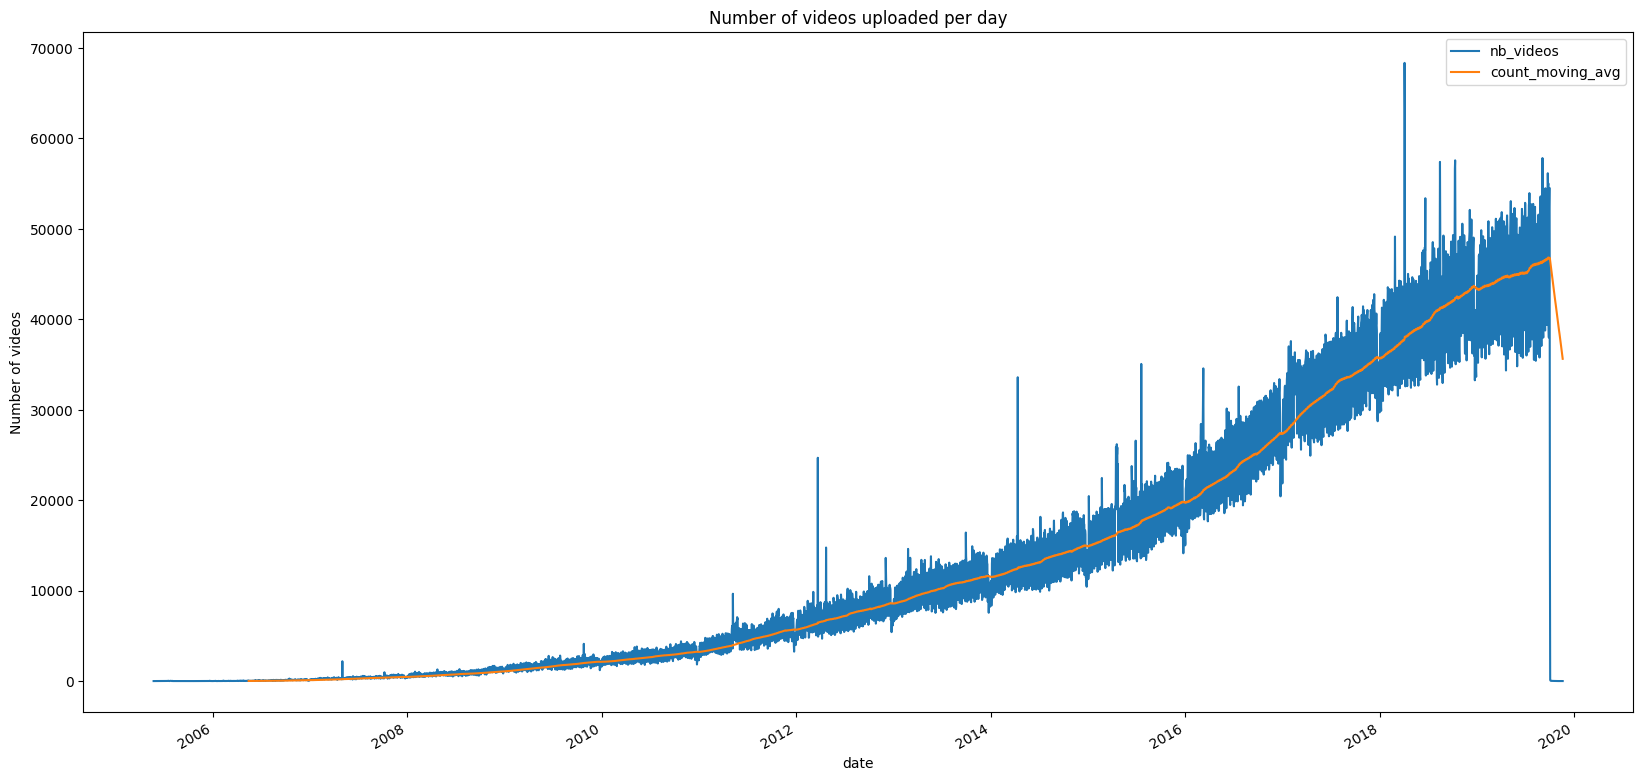

In [4]:
nb_videos_df['nb_videos_cc'] = pd.Series(climate_videos_df.index.value_counts())
nb_videos_df['nb_videos_cc'].fillna(0, inplace=True)
nb_videos_df['count_moving_avg'] = nb_videos_df['nb_videos'].rolling(window=200).mean()

nb_videos_df[['nb_videos', 'count_moving_avg']].plot(figsize=(20, 10))
plt.title('Number of videos uploaded per day')
plt.ylabel('Number of videos')
plt.show()

Based on this graph, we:
- keep the data 1 month before the crawl date 2019-09-29 because the data is less relevant and incomplete after this date.
- start from 2010 because the number of videos is very low before this date and would not be representative.

In [7]:
nb_videos_df = restrict_time_period(nb_videos_df)
climate_videos_df = restrict_time_period(climate_videos_df)
nb_videos_cat_df = restrict_time_period(nb_videos_cat_df)
nb_videos_views_df = restrict_time_period(nb_videos_views_df)

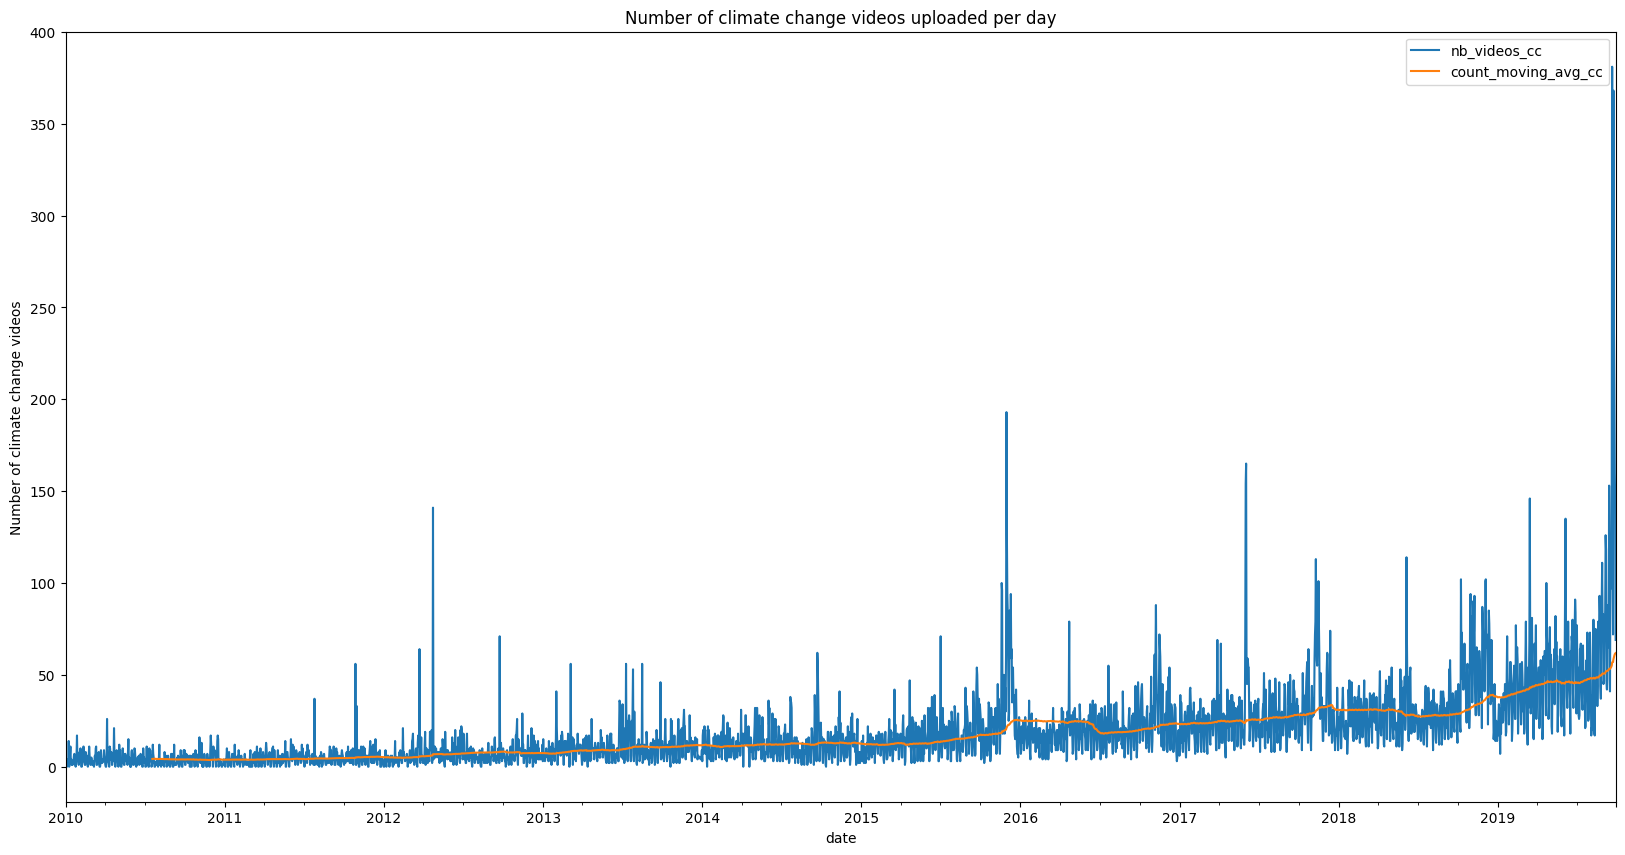

In [8]:
nb_videos_df['count_moving_avg_cc'] = nb_videos_df['nb_videos_cc'].rolling(window=200).mean()
nb_videos_df[['nb_videos_cc', 'count_moving_avg_cc']].plot(figsize=(20, 10))

plt.title('Number of climate change videos uploaded per day')
plt.ylabel('Number of climate change videos')
plt.show()

If we just look at the number of climate change videos being published every day, we see that the trend is increasing over time. However, the total number of videos is also increasing over time, so we have to look at the ratio to see how significant the first trend is.

Now we will look at the evolution of the **proportion** of youtube videos related to climate change. Since there is high variance, we will look at this with different granularities (dayly, weekly, monthly):

In [9]:
# compute percentages
percentage_day = 100* nb_videos_df['nb_videos_cc'] / nb_videos_df['nb_videos']
percentage_week = 100* nb_videos_df['nb_videos_cc'].resample('W').sum() / nb_videos_df['nb_videos'].resample('W').sum()
percentage_month = 100* nb_videos_df['nb_videos_cc'].resample('M').sum() / nb_videos_df['nb_videos'].resample('M').sum()
percentage_year = 100* nb_videos_df['nb_videos_cc'].resample('Y').sum() / nb_videos_df['nb_videos'].resample('Y').sum()

percentages = [percentage_day, percentage_week, percentage_month, percentage_year]

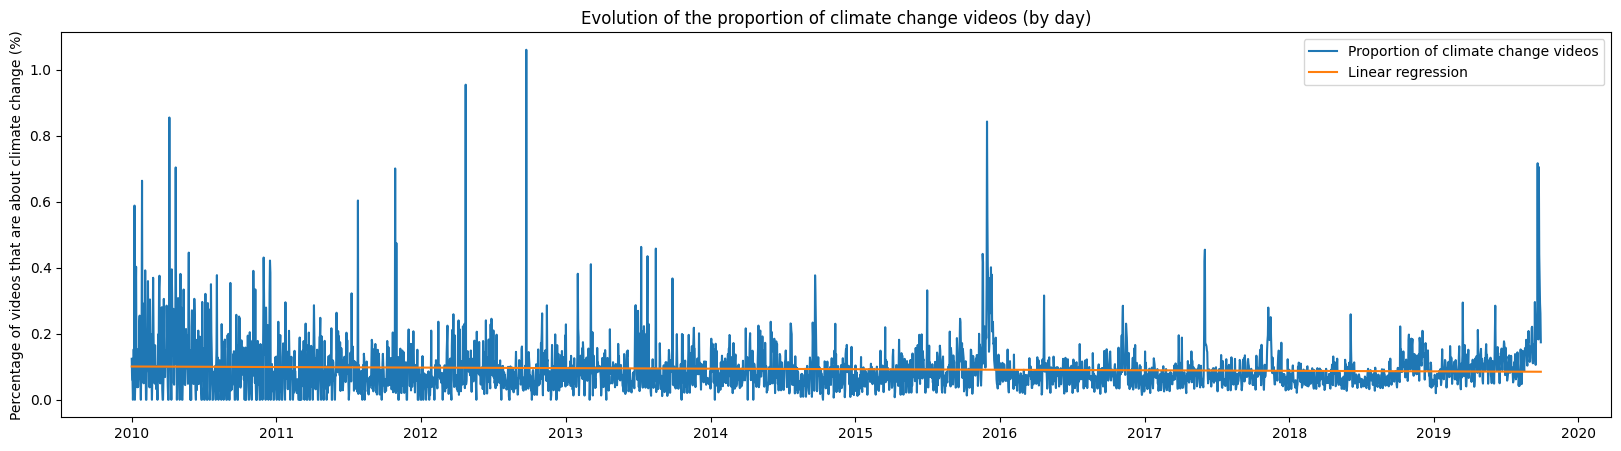

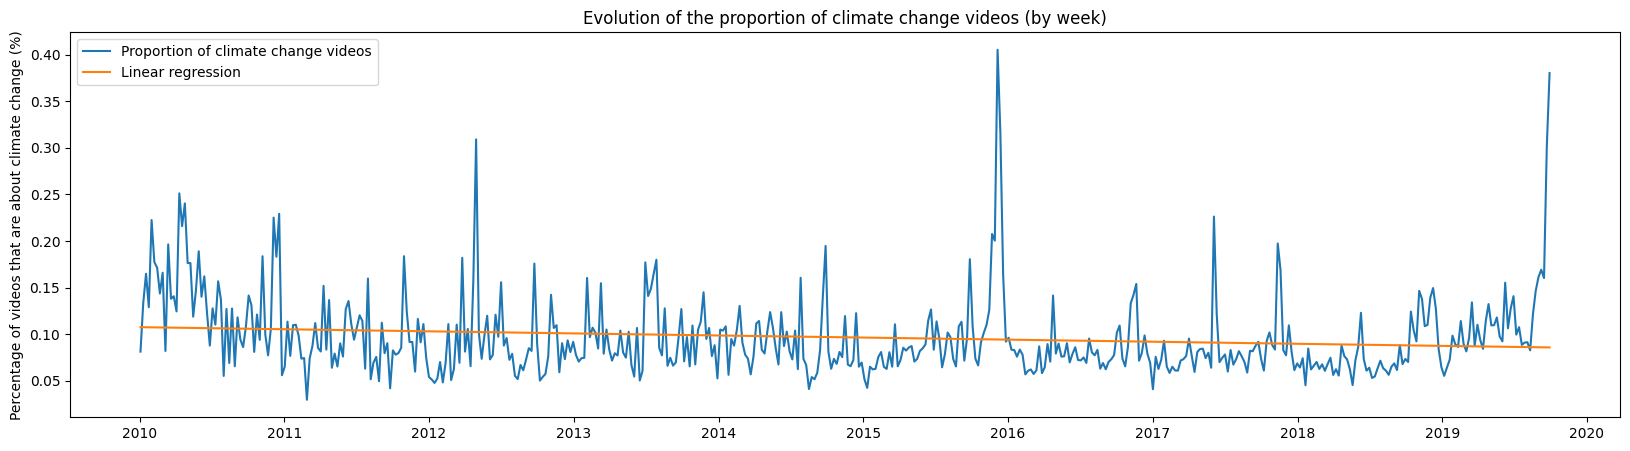

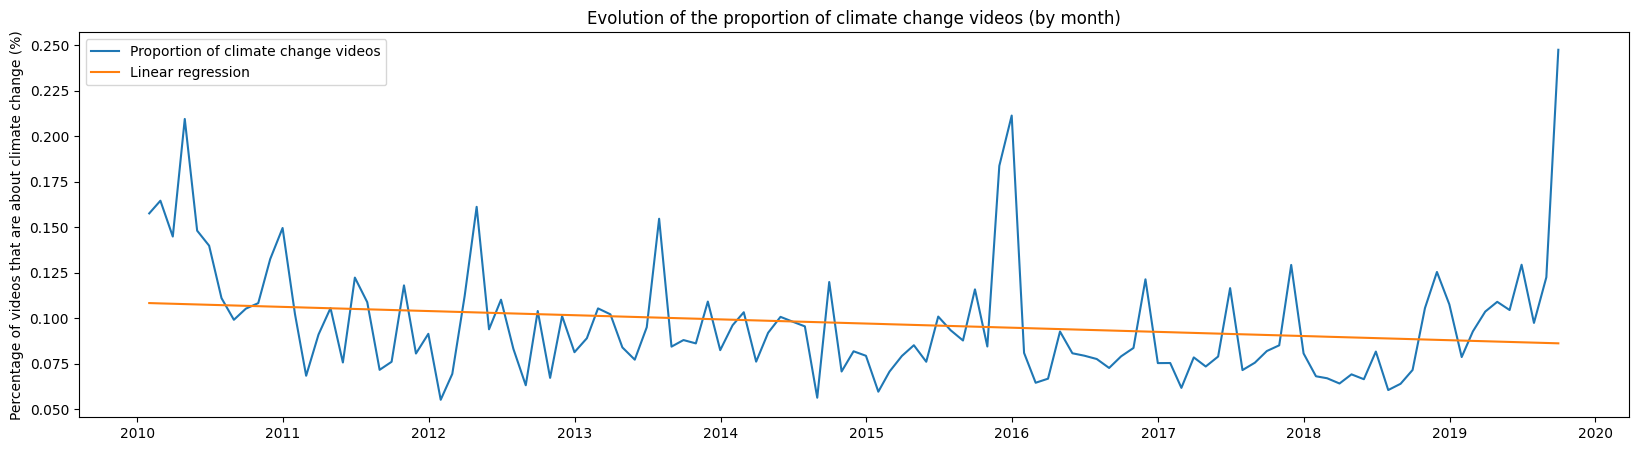

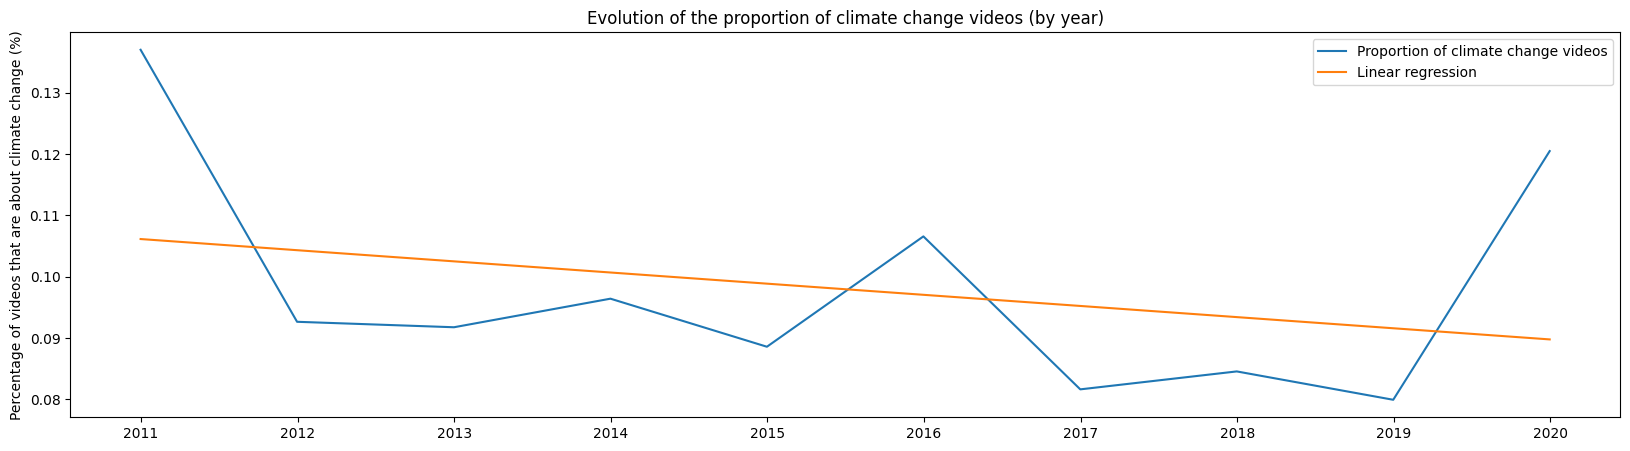

In [10]:
# plot percentages
sample_rate = ['day', 'week', 'month','year']

for i in range(4):
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.plot(percentages[i].index, percentages[i].values, label='Proportion of climate change videos')
    ax.plot(percentages[i].index, get_linear_fit(percentages[i]), label='Linear regression')
    ax.set_title(f'Evolution of the proportion of climate change videos (by {sample_rate[i]})')
    ax.set_ylabel('Percentage of videos that are about climate change (%)')
    plt.legend()
    plt.show()

We see that the proportion slightly decreases over time. Since we saw that more and more climate change videos were being published every day, this means that the number of CC videos is increasing at a slightly slower rate than the total number of videos on youtube.

#### Number of views

Let's look at the (average) number of views of climate change videos vs of all videos across time:

In [11]:
#number of CC videos
nb_videos_views_df['nb_videos_cc'] = nb_videos_df['nb_videos_cc']
# number of views of CC videos
nb_videos_views_df['nb_views_cc'] = pd.Series(climate_videos_df.groupby(climate_videos_df.index).nb_views.sum())

# monthly averages
avg_month_tot = nb_videos_views_df['nb_views'].resample('M').sum() / nb_videos_views_df['nb_videos'].resample('M').sum()
avg_month_cc = nb_videos_views_df['nb_views_cc'].resample('M').sum() / nb_videos_views_df['nb_videos_cc'].resample('M').sum()


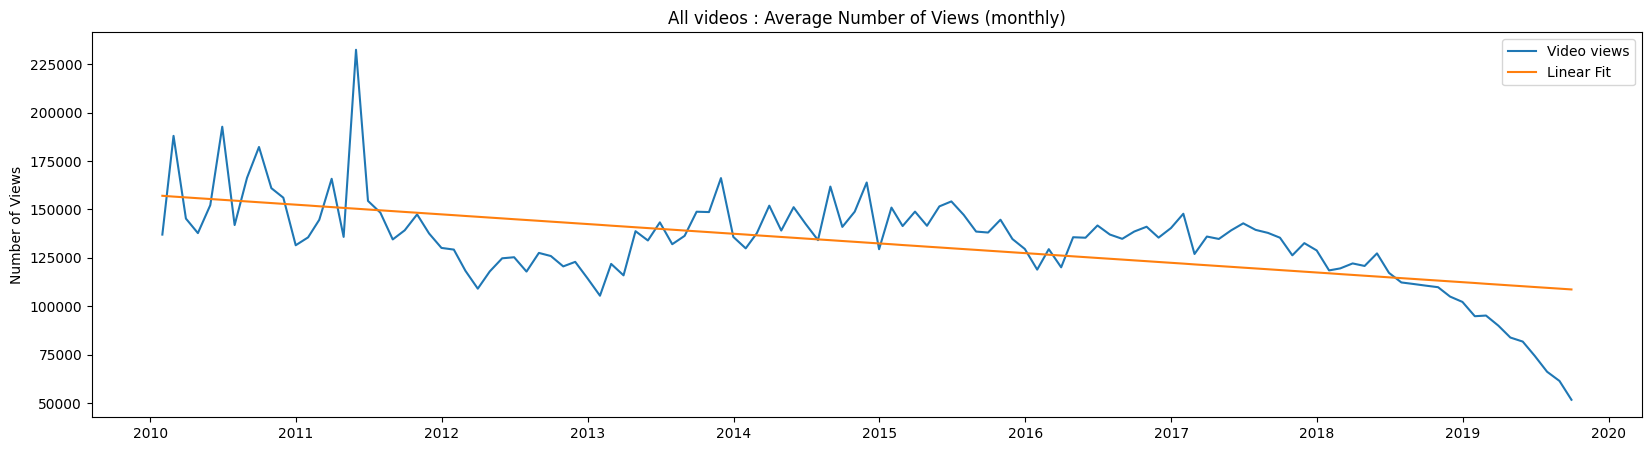

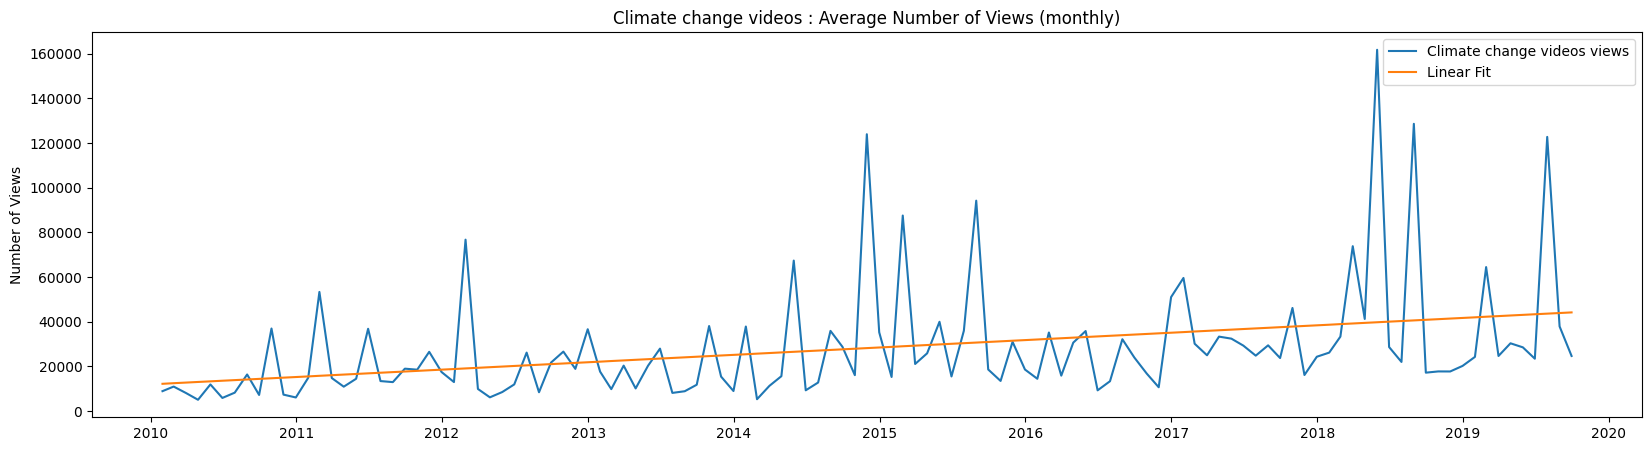

In [12]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(avg_month_tot.index, avg_month_tot.values, label='Video views')
ax.plot(avg_month_tot.index, get_linear_fit(avg_month_tot), label='Linear Fit')
ax.set_title('All videos : Average Number of Views (monthly)')
ax.set_ylabel('Number of Views')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(avg_month_cc.index, avg_month_cc.values, label='Climate change videos views')
ax.plot(avg_month_cc.index, get_linear_fit(avg_month_cc), label='Linear Fit')
ax.set_title('Climate change videos : Average Number of Views (monthly)')
ax.set_ylabel('Number of Views')
plt.legend()
plt.show()

We see that :
- for all videos, the earlier ones tend to cumulate more views in total (have been around for a longer time)
- however, for climate change videos, this is much more steady: people seem to watch less the old videos about climate change (becomes quickly outdated?)

Note that we will try to interpret the view spikes later in the analysis.

### Focusing on key categories
Now, let's focus on just some key categories :
- `Education`
- `News & Politics`
- `Nonprofits & Activism`
- `Science & Technology`

In [13]:
key_categories = ['Science & Technology', 'Education', 'News & Politics', 'Nonprofits & Activism']

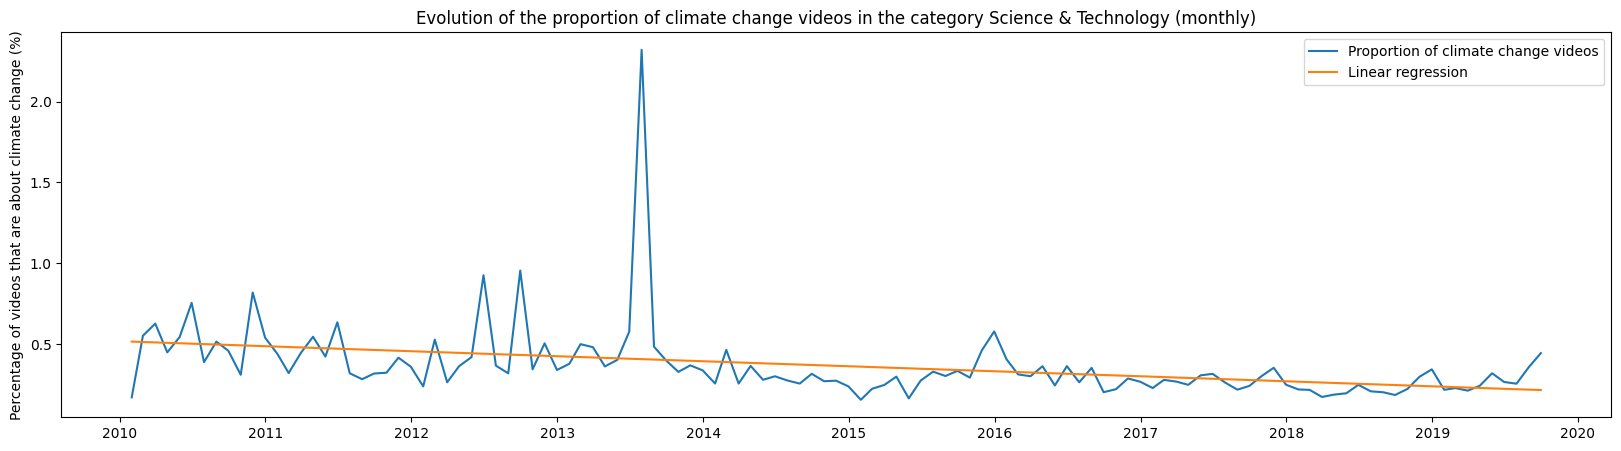

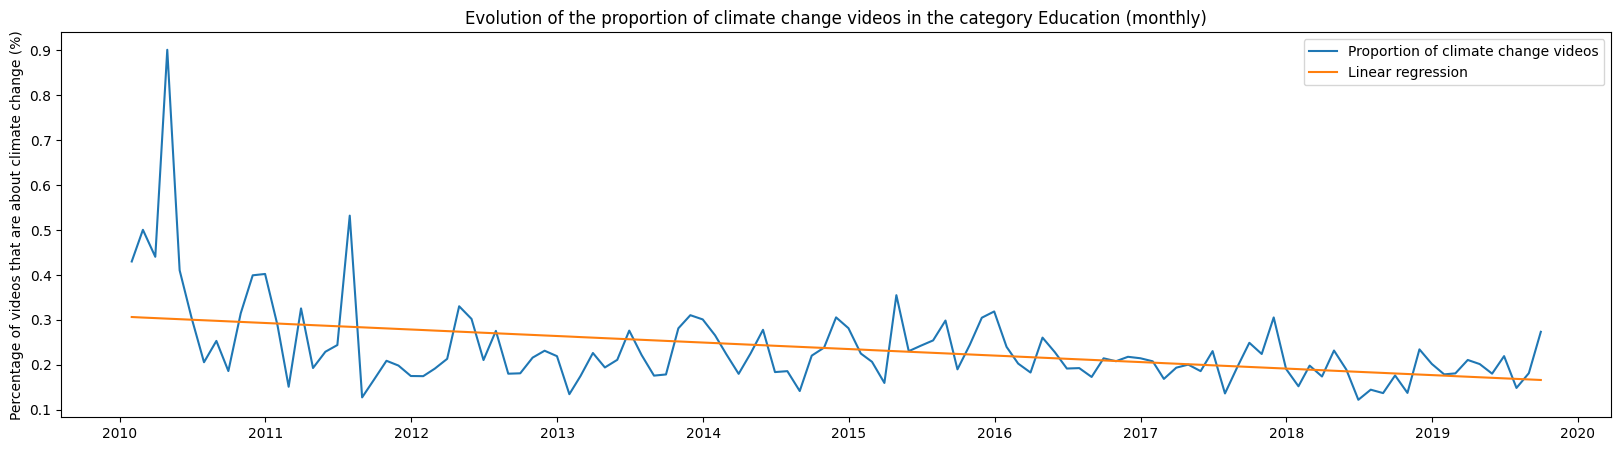

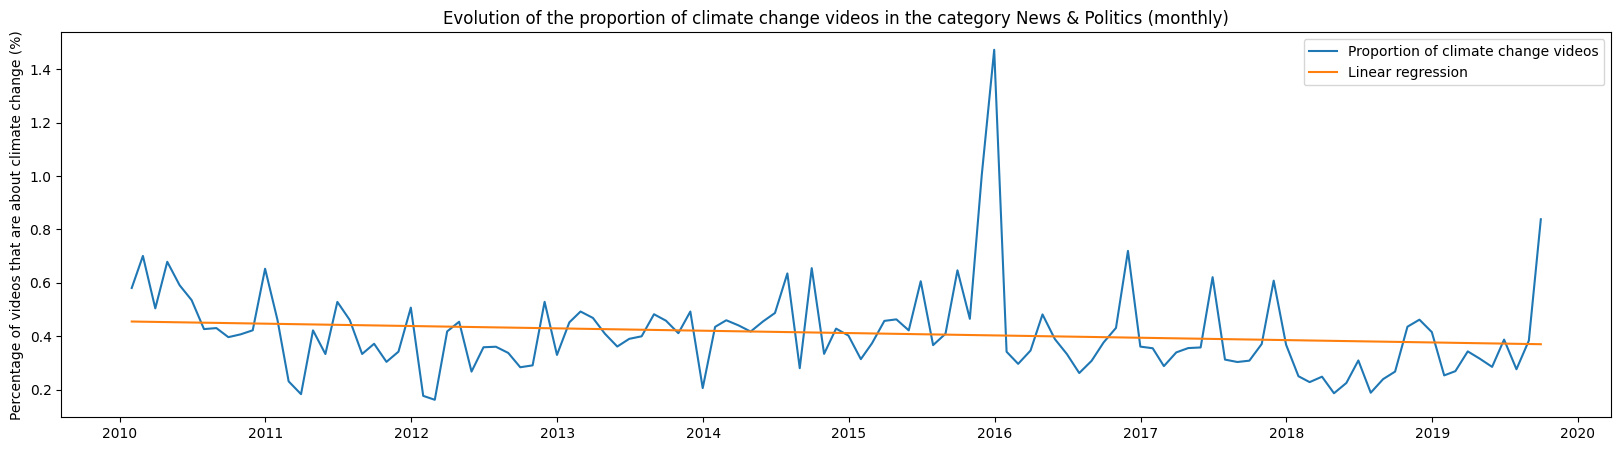

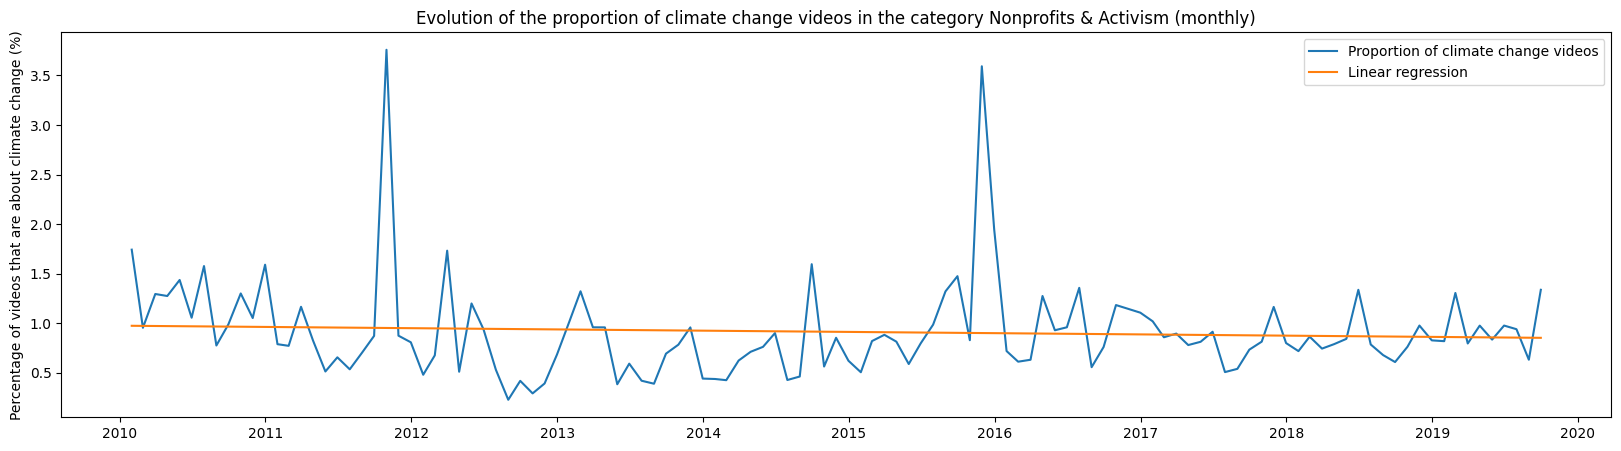

In [14]:
for category in key_categories:
    plot_evolution(category, nb_videos_cat_df, climate_videos_df)

Some interesting spikes (not the same in every category): to be interpreted later

### Channel-wise analysis
How are the channels taking over this topic?

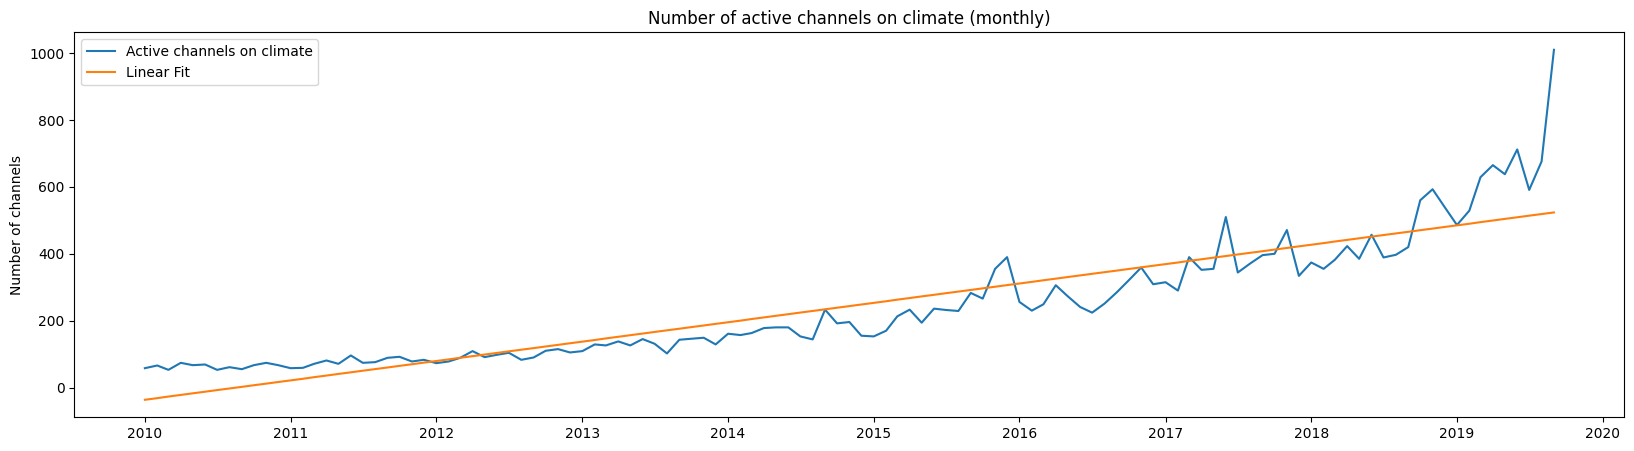

In [15]:
monthly_channel_counts = climate_videos_df.groupby(climate_videos_df.index.to_period('M'))['channel'].nunique()
monthly_channel_counts.index = monthly_channel_counts.index.to_timestamp()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(monthly_channel_counts.index, monthly_channel_counts.values, label='Active channels on climate')
ax.plot(monthly_channel_counts.index, get_linear_fit(monthly_channel_counts), label='Linear Fit')
ax.set_title('Number of active channels on climate (monthly)')
ax.set_ylabel('Number of channels')
plt.legend()
plt.show()


In this first part, all the comparisons were between all climate and non climate videos, but this is unbalanced and not random : there could be some confounders in the attribution (for example, maybe the channels publishing climate related videos have less subscribers than the others overall, so we shouldn't draw the conclusion now that climate videos get less views just because they are climate videos).

Later on, we will perform the same comparisons between climate and non climate videos, but on a matching (on the date, category and views) to try to isolate the effect of the property "being about climate change".

#### What are climate change related videos main youtube categories and how does it compare to overall youtube? Was there an evolution of these categories ? 

In [ ]:
all_sample_videos_path = "data/sampled_dataset_1percent.jsonl"
climate_videos_df_path = "data/climate_videos_v3.jsonl"
nb_videos_by_cat_path = "data/nb_videos_by_cat.jsonl"

In [ ]:
climate_videos_df = pd.read_json(final_filter_climate_videos_path, lines=True)
all_videos_sample_df = pd.read_json(all_sample_videos_path, lines=True)

In [ ]:
#we restict the date as done before but non for early videos
end_date = '2019-09-29'
climate_videos_df['upload_date'] = pd.to_datetime(climate_videos_df['upload_date'])
climate_videos_df = climate_videos_df[climate_videos_df['upload_date'] < end_date]
all_videos_sample_df['upload_date'] = pd.to_datetime(all_videos_sample_df['upload_date'])
all_videos_sample_df = all_videos_sample_df[all_videos_sample_df['upload_date'] < end_date]

In [ ]:
climate_videos_df['categories'] = climate_videos_df['categories'].replace('', 'not specified')

#Counting the number of videos in each category
category_counts_climate = climate_videos_df['categories'].value_counts()
category_counts_all = nb_videos_by_cat = pd.read_json(nb_videos_by_cat_path, lines=True)
category_counts_all['categories'] = category_counts_all['categories'].replace('', 'not specified')
category_counts_all = category_counts_all.set_index('categories').squeeze()
categories = category_counts_climate.index

fig = px.pie(category_counts_climate.reset_index(),
             values='count',
             names='categories',
             title='Categories Distribution - Climate Change related Videos',
             width=800,
             height=800,
             category_orders={"categories":categories.to_list()[::-1]})#making sure the order is the same as the one in the other pie chart
fig.update_layout(showlegend=False)
fig.update_traces( textinfo='percent+label', textposition='inside')

fig.show()

fig = px.pie(category_counts_all.reset_index(),
             values='count',
             names='categories',
             title='Categories Distribution - All Videos',
             width=800,
             height=800,
             category_orders={"categories":categories.to_list()[::-1]})
fig.update_traces(textinfo='percent+label', textposition='inside')
fig.update_layout(showlegend=False)
fig.show()

As we could expected, main categories of climate related videos are very different from overall YouTube. Some categories such as *Gaming* and *Music* are very important on overall YouTube but quasi absent among climate change related videos. On the otherside, some gain in importance in climate change related videos  : *New & Politics*, *Education*, *Science & Tehnology*, *Non Profit & Activism* 
These 4 account for 80% of climate change related videos, and 50% for *News & Politics*. On Youtube, it seems like climate change is more of a political/news topic than a Science/education topic. Was it always the case ?

Based on this category analysis we choose some relevent categories (those with more than 2500 videos related to climate change)

In [ ]:
relevent_cat = category_counts_climate[category_counts_climate > 2500].reset_index()
relevent_cat = relevent_cat.drop(columns = ['count'])['categories'].to_list()
print(relevent_cat)

['News & Politics', 'Education', 'Science & Technology', 'Nonprofits & Activism', 'People & Blogs', 'Entertainment']


In [ ]:
climate_videos_df['quarter'] = pd.to_datetime(climate_videos_df['upload_date']).dt.to_period('Q')

evolution_category_counts_climate = (climate_videos_df[['categories', 'quarter', 'display_id']].groupby(
                                                                    ['categories', 'quarter']).aggregate(
                                                                    'count')).unstack(
                                                                    fill_value=0).stack().reset_index() #add 0 values when there is no video in a category for a given time


evolution_category_counts_climate = evolution_category_counts_climate.rename(columns={'display_id': 'count'})
evolution_category_counts_climate['quarter'] = evolution_category_counts_climate['quarter'].astype(str)
evolution_category_counts_climate = evolution_category_counts_climate

fig = px.area(evolution_category_counts_climate.reset_index(), x="quarter", y="count", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.update_layout(title="Evolution of the number of climate change related videos uploaded by year quarter")
fig.show()

total_counts = evolution_category_counts_climate.groupby('quarter')['count'].sum() #number of videos added per time unit
evolution_category_counts_climate['proportion'] = evolution_category_counts_climate.apply(lambda row: row['count']/total_counts[row['quarter']], axis=1)

fig = px.area(evolution_category_counts_climate.reset_index(), x="quarter", y="proportion", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.update_layout(title="Evolution of the climate change related uploaded videos categories distribution by year quarter")
fig.show()

In [ ]:
nb_videos_by_date_cat_path = "data/nb_videos_by_date_cat.jsonl"
evolution_category_counts_all = pd.read_json(nb_videos_by_date_cat_path, lines=True)

evolution_category_counts_all['categories'] = evolution_category_counts_all['categories'].replace('', 'not specified')

evolution_category_counts_all['upload_date'] = pd.to_datetime(evolution_category_counts_all['upload_date'])
evolution_category_counts_all = evolution_category_counts_all[evolution_category_counts_all['upload_date'] < '2019-09-29']
evolution_category_counts_all['quarter'] = evolution_category_counts_all['upload_date'].dt.to_period('Q')

evolution_category_counts_all = (evolution_category_counts_all[['categories', 'quarter', 'count']].groupby(
                                                                    ['categories', 'quarter']).agg({'count':'sum'})).unstack(
                                                                    fill_value=0).stack().reset_index() #add 0 values when there is no video in a category for a given time

evolution_category_counts_all['quarter'] = evolution_category_counts_all['quarter'].astype(str)
evolution_category_counts_all = evolution_category_counts_all[~evolution_category_counts_all['categories'].isin(['Shows','Movies'])] # 0  everywhere

fig = px.area(evolution_category_counts_all, x="quarter", y="count", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.show()
fig.update_layout(title="Evolution of the number of uploaded videos by year quarter")

total_counts = evolution_category_counts_all.groupby('quarter')['count'].sum() #number of videos added per time unit
evolution_category_counts_all['proportion'] = evolution_category_counts_all.apply(lambda row: row['count']/total_counts[row['quarter']], axis=1)

fig = px.area(evolution_category_counts_all, x="quarter", y="proportion", color="categories", category_orders={"categories":categories.to_list()[::-1]})
fig.update_layout(title="Evolution of the uploaded videos categories distribution by year quarter")
fig.show()

We can see that Climate Change was always mainly in *News & Politics* categorie but this tends to drastically increase as it increase on overall YouTube, but in greater proportions. We can also draw these interesting fact:
- Climate Change was much more of a *Non Profit & Activism* topic in 2010 than in 2019 (20% versus 7% of  uploaded videos)
- Climate Change was much more of a *Science & Technology* topic in 2013 than in 2019 (38% versus 7% of uploaded videos)
- There was up to 10% of Climate change related videos in *Comedy* but nearly 0 in 2019, we do not joke about climate change anymore.



### Are videos about climate change more popular than other videos ?

In [ ]:
# add to the climate_videos_df 2 columns : name of channel and nb of subscribers
cc_vids_df = climate_videos_df.merge(ch_df[['name', 'subs']], on ='channel', how ='left').fillna(0)
cc_vids_df.set_index('display_id', inplace=True)
cc_vids_df.rename(columns={'nb_views': 'view_count'}, inplace=True)

In [ ]:
# adds a column that counts the ratio of climate videos to total videos
ratios = cc_vids_df['channel'].value_counts().reset_index()
ratios.columns = ['channel', 'cc_vids_count']
ch_cc_df = ch_df.merge(ratios, on ='channel', how ='left').fillna(0)
ch_cc_df['proportion_cc_vids'] = ch_cc_df['cc_vids_count']/ch_cc_df['vids_count']

In [ ]:
# df with the metadata of all channels
ch_stats_df = timeseries_df[['channel', 'views', 'videos']].groupby('channel').last()

# df with the metadata of channels with climate videos
ch_cc_stats_df = cc_vids_df[['channel', 'view_count']].groupby('channel').agg(['sum', 'count'])
ch_cc_stats_df.columns = ch_cc_stats_df.columns.to_flat_index()
ch_cc_stats_df.rename(columns={('view_count', 'sum'): 'cc_views', ('view_count', 'count'): 'cc_videos'}, inplace=True)

# df with only climate change channels and their stats on with and without climate videos
ch_cc_stats_df = ch_stats_df.merge(ch_cc_stats_df, how='inner', on='channel')
ch_cc_stats_df['avg_views_wo_cc'] = (ch_cc_stats_df['views'] - ch_cc_stats_df['cc_views'])/(ch_cc_stats_df['videos'] - ch_cc_stats_df['cc_videos'])
ch_cc_stats_df['avg_views_w_cc'] = ch_cc_stats_df['cc_views']/ch_cc_stats_df['cc_videos']
ch_cc_stats_df['avg_views'] = ch_cc_stats_df['views']/ch_cc_stats_df['videos']

# remove odd values
ch_cc_stats_df = ch_cc_stats_df[ch_cc_stats_df['cc_videos']<ch_cc_stats_df['videos']].dropna()
ch_cc_stats_df = ch_cc_stats_df[ch_cc_stats_df['avg_views_wo_cc']>0].dropna()

In [ ]:
model = smf.formula.ols(formula='avg_views_wo_cc ~ avg_views_w_cc', data=ch_cc_stats_df, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        avg_views_wo_cc   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     1570.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.40e-303
Time:                        19:48:54   Log-Likelihood:                -86089.
No. Observations:                5725   AIC:                         1.722e+05
Df Residuals:                    5723   BIC:                         1.722e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.123e+05   1.09e+04     10.

This regression tells us that the more views a channel has on its other videos, the even more views they are going to get on a climate change video with a coefficient of 0.3.
Let's look at this result more in details:

In [ ]:
ch_cc_df = ch_cc_stats_df.merge(ch_cc_df[['channel', 'name', 'subs', 'proportion_cc_vids']], on ='channel', how ='inner').fillna(0)
ch_cc_df.set_index('name', inplace=True)

In [ ]:
colors = ['darkgrey', 'forestgreen']

In [ ]:
fig = px.scatter(ch_cc_df, x='avg_views_w_cc', y='avg_views_wo_cc',
                 size='cc_videos', color='proportion_cc_vids',
                 color_continuous_scale='RdYlGn',
                 opacity=ch_cc_df['proportion_cc_vids'],
                 labels={'avg_views_w_cc': 'Average views for videos about climate change',
                         'avg_views_wo_cc': 'Average views for videos not about climate change'},
                 title='Scatter plot of the average views of a video about climate change vs not & the importance of climate change in the channel',
                 hover_name=ch_cc_df.index)

fig.add_trace(go.Scatter(x=[0, 10**7], y=[0, 10**7], mode='lines', line=dict(color='lightgray'), name='x=y'))

fig.update_layout(
    xaxis_type="log",
    yaxis_type="log",
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    xaxis_title='Average number of views for videos about climate change',
    yaxis_title='Average nb of views for videos not about climate change'
)

fig.show()


This scatter plot shows us the views of channels that contain climate change videos. The bigger the dot, the more videos on climate change they have. The greener the dot, the more ratio of climate videos their channel contain. We can see that the darker dots seem to be below the x=y line meaning the have more views on climate videos than on their others.

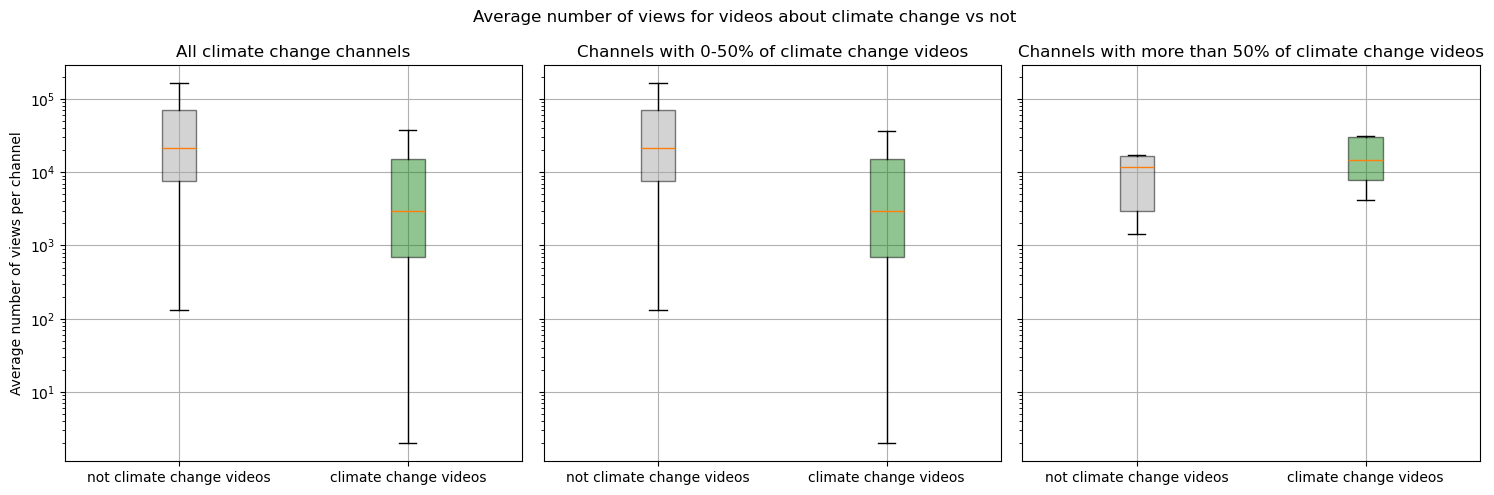

In [ ]:
ch_cc_df_first = ch_cc_df[ch_cc_df['proportion_cc_vids'] <= 0.5].dropna()
ch_cc_df_second = ch_cc_df[ch_cc_df['proportion_cc_vids'] > 0.5].dropna()

fig, (pA, pB, pC) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
labels = ['not climate change videos', 'climate change videos']

a = pA.boxplot(ch_cc_df[['avg_views_wo_cc', 'avg_views_w_cc']], patch_artist=True, showfliers=False, labels=labels)
b = pB.boxplot(ch_cc_df_first[['avg_views_wo_cc', 'avg_views_w_cc']], patch_artist=True, showfliers=False, labels=labels)
c = pC.boxplot(ch_cc_df_second[['avg_views_wo_cc', 'avg_views_w_cc']], patch_artist=True, showfliers=False, labels=labels)

for x in [a, b, c]:
    for patch, color in zip(x['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

pA.set_yscale("log")
fig.suptitle('Average number of views for videos about climate change vs not')
titles = ['All climate change channels', 'Channels with 0-50% of climate change videos', 'Channels with more than 50% of climate change videos']
for(ax, title) in zip([pA, pB, pC], titles):
    ax.set_title(title)
    ax.grid()
pA.set_ylabel('Average number of views per channel')
fig.tight_layout()
plt.show()

This box plot shows that in average, videos on climate change are not very popular on YouTube, especially if the channel is not specialized in the topic. Making climate change videos will not make you famous. However, if your channel has a high ratio of climate videos, then you might have an audience that is interested in the topic and continuing to make videos about it will gain you views.

### Observational study: what implications does being a climate change-related video have on audience response?

**First number of views**

We perform a match by categories and months since these could both be confounders impacting the number of views.

We only select the non climate ralted videos in the all videos sample and restrict ourselves to columns we need.

In [ ]:
columns = ['categories', 'month', 'view_count', 'display_id', 'like_count', 'dislike_count']

obs_study_climate_videos_df = climate_videos_df.dropna(subset=['view_count', 'like_count', 'dislike_count'])
obs_study_climate_videos_df = obs_study_climate_videos_df[(obs_study_climate_videos_df['view_count'] > 0) &
                                                          (obs_study_climate_videos_df['like_count'] <= obs_study_climate_videos_df['view_count']) &
                                                          (obs_study_climate_videos_df['dislike_count'] <= obs_study_climate_videos_df['view_count'])]

obs_study_climate_videos_df['month'] = pd.to_datetime(obs_study_climate_videos_df['upload_date']).dt.to_period('M')
obs_study_climate_videos_df['is_climate'] = 1

all_videos_sample_df['categories'] = all_videos_sample_df['categories'].replace('', 'not specified')

obs_study_all_videos_df = all_videos_sample_df.dropna(subset=['view_count', 'like_count', 'dislike_count'])
obs_study_all_videos_df = obs_study_all_videos_df[(obs_study_all_videos_df['view_count'] > 0) &
                                                (obs_study_all_videos_df['like_count'] <= obs_study_all_videos_df['view_count']) &
                                                (obs_study_all_videos_df['dislike_count'] <= obs_study_all_videos_df['view_count'])]

obs_study_all_videos_df['month'] = pd.to_datetime(obs_study_all_videos_df['upload_date']).dt.to_period('M')


obs_study_all_videos_df = obs_study_all_videos_df.merge(obs_study_climate_videos_df,how='left', on=obs_study_all_videos_df.columns.to_list())
obs_study_all_videos_df['is_climate'] = obs_study_all_videos_df['is_climate'].fillna(0)

obs_study_non_climate_videos_df = obs_study_all_videos_df[obs_study_all_videos_df['is_climate'] == 0]

columns = columns + ['is_climate']

obs_study_climate_videos_df = obs_study_climate_videos_df[columns]
obs_study_non_climate_videos_df = obs_study_all_videos_df[columns]

In [ ]:

#We perform exact matching on the categories and the month
matching_df = obs_study_climate_videos_df.merge(right = obs_study_non_climate_videos_df,
                                                on = ['categories', 'month'],
                                                suffixes=('_climate', '_non_climate'))

#Since we have multiple videos for each category and month, we take the mean of the view count for the non climate videos
matching_df = matching_df.groupby(['categories','display_id_climate', 'view_count_climate', 'is_climate_climate']).agg({
    'view_count_non_climate' : 'mean' ,
    'display_id_non_climate' : (lambda x : ",".join(x)),
    'is_climate_non_climate' : (lambda x : 0)
}
).reset_index()

matching_df = matching_df.reset_index()


In [ ]:
#building the obsvervational study dataframe
climate_matched = matching_df[['categories','display_id_climate', 'view_count_climate', 'is_climate_climate']]
cols = ['categories','display_id', 'view_count', 'is_climate']

climate_matched = climate_matched.rename(columns = {old : new for old,new in zip(climate_matched.columns, cols)})

non_climate_matched = matching_df[['categories','display_id_non_climate', 'view_count_non_climate', 'is_climate_non_climate']]
non_climate_matched = non_climate_matched.rename(columns = {old : new for old,new in zip(non_climate_matched.columns, cols)})


obs_study_df = pd.concat([climate_matched,non_climate_matched])

In [ ]:
model = smf.ols(formula='view_count ~ is_climate', data=obs_study_df)
result = model.fit()
intercept, coef = result.params
_, coef_p = result.pvalues

regression_results_views = {'all' : {'intercept': intercept, 'is_climate_coeff': coef, 'coeff_p-value': coef_p, 'climate_intercept': intercept + coef}}

for category in relevent_cat:
    model = smf.ols(formula='view_count ~ is_climate', data=obs_study_df[obs_study_df['categories'] == category])
    result = model.fit()
    intercept, coef = result.params
    _, coef_p = result.pvalues
    result_dict = {'intercept': intercept, 'is_climate_coeff': coef, 'coeff_p-value': coef_p, 'climate_intercept': intercept + coef}
    regression_results_views[category] = result_dict

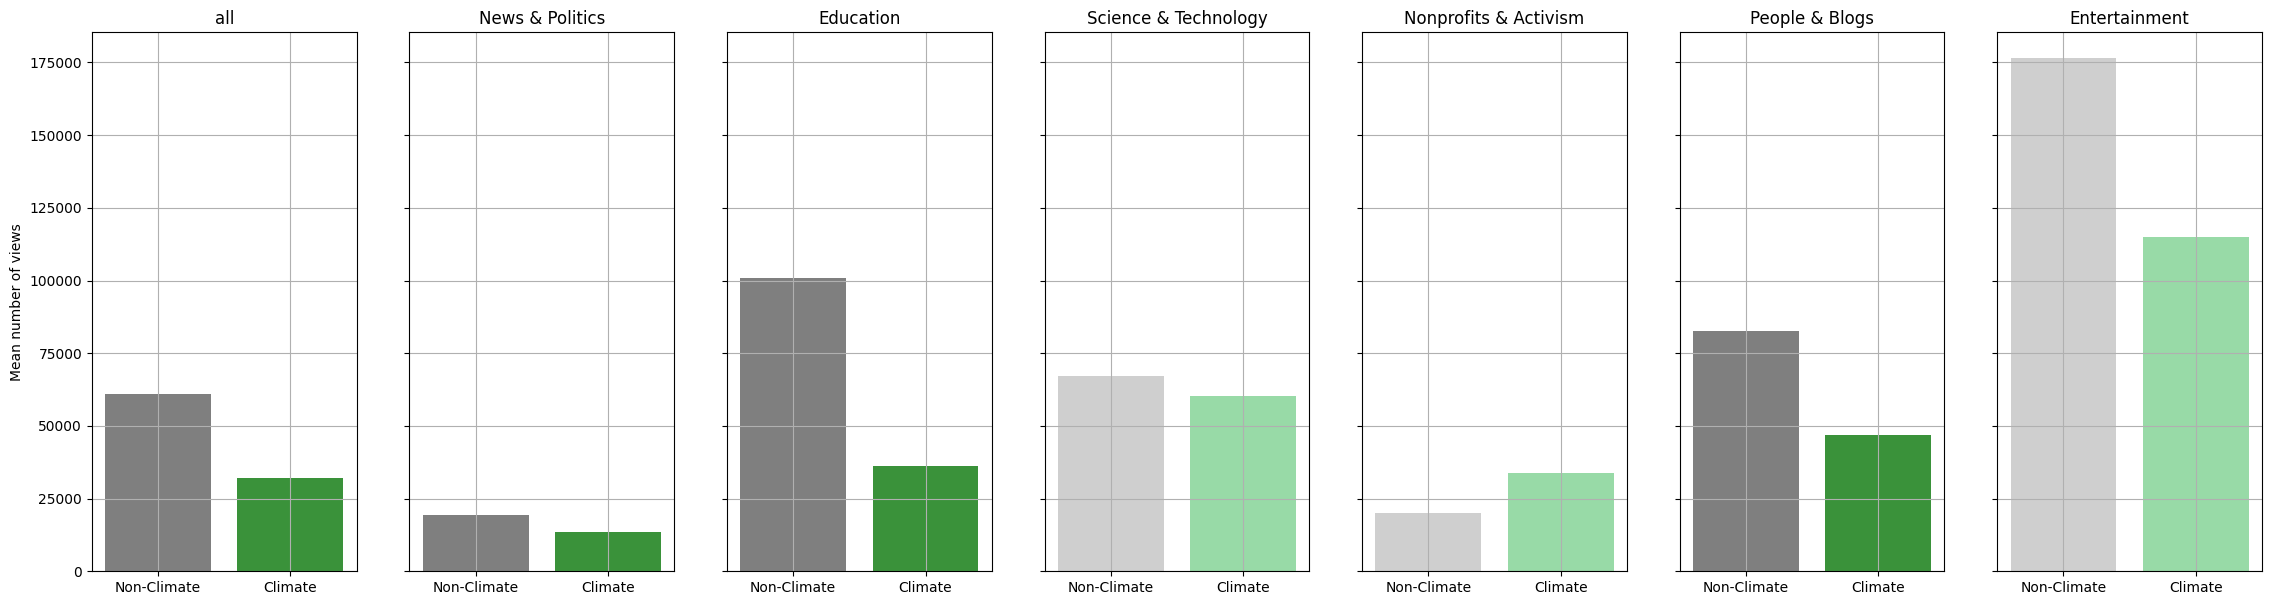

In [ ]:
labs = ['Non-Climate', 'Climate']

fig, axs = plt.subplots(1, len(relevent_cat)+ 1 , figsize=(4*(len(relevent_cat)+1), 7), sharey=True)

statistically_relevent_colors = (sns.color_palette()[7], sns.color_palette()[2])
non_statistically_relevent_colors = (sns.color_palette('pastel')[7], sns.color_palette('pastel')[2])

for idx, category in enumerate(['all'] + relevent_cat):
        non_climate_views = regression_results_views[category]['intercept']
        climate_views = regression_results_views[category]['climate_intercept']
        
        if regression_results_views[category]['coeff_p-value'] < 0.05:
            colors = statistically_relevent_colors
        else:
            colors = non_statistically_relevent_colors

        sns.barplot(
            x=labs,
            y=[non_climate_views, climate_views],
            palette = colors,
            ax=axs[idx]
        )
        axs[idx].set_title(f'{category}')
        axs[idx].grid(True)

axs[0].set_ylabel('Mean number of views')

plt.show()

Note: transparent colors when the analysis is not statistacally relevent (p-value > 0.05)

As we can see being a climate change related clearly negativeley impacts the number of view a video may have. Overall there is a decrease of more than 25000 views. This tendency is smaller for some categories such as *New & Politics* or bigger for *Education*. Namely, in *Education* Climate change related have much less views than Non Climate Videos.

*Non Profit and Activism* is the only category where being a climate change related videos positively impact the number of view, though this impact is not statistcally relevant

Now we want to study if being a climate videos influence the number of likes, dislikes and related. We also perform a a matching on the number of views since this may be confounder influencing these likes and dislikes number

We use a special greedy matching given the size of the data. For each perfect categories,month match, we match a climate videos to the non climate videos that has the closest number of views and iterate that process until all climate videos that can be matched are matched.
"Can be matched" meaning:
- There exist perfect matching on categories and month
- There exist videos with less than 35% of relative difference in number of views within this perfect match (and not already matched with another cliamte video)

In [ ]:
obs_study_climate_videos_df = obs_study_climate_videos_df.sort_values('view_count')
obs_study_climate_videos_df['view_count'] = obs_study_climate_videos_df['view_count'].astype(int)
obs_study_climate_videos_df['view_count_climate'] = obs_study_climate_videos_df['view_count']

obs_study_non_climate_videos_df = obs_study_non_climate_videos_df.sort_values('view_count')
obs_study_non_climate_videos_df['view_count'] = obs_study_non_climate_videos_df['view_count'].astype(int)
obs_study_non_climate_videos_df['view_count_non_climate'] = obs_study_non_climate_videos_df['view_count']

not_matched_climate_videos_df = obs_study_climate_videos_df #climate videos who were not matched (all of them for now)
not_matched_non_climate_videos_df = obs_study_non_climate_videos_df #non climate videos who were not matched (all of them for now)

matching_df = pd.DataFrame()

while not_matched_climate_videos_df.shape[0] > 0: #purpose is to matched as many climate videos as possible

    not_matched_climate_videos_df = not_matched_climate_videos_df.sort_values('view_count') #sorting to be able to use merge_asof
    not_matched_non_climate_videos_df = not_matched_non_climate_videos_df.sort_values('view_count')


    matching_2_df = pd.merge_asof(
                                left = not_matched_climate_videos_df,
                                right = not_matched_non_climate_videos_df, 
                                on='view_count', #nearest match on view count
                                by=['categories', 'month'], #exact match on categories and month
                                suffixes=('_climate', '_non_climate'), direction = 'nearest')
    
    matching_2_df['relative_diff'] = (matching_2_df['view_count_climate'] - matching_2_df['view_count_non_climate']).abs()/matching_2_df[['view_count_non_climate', 'view_count_climate']].max(axis=1)
                                            #view_count relative differences in the match we found
    
    #allowing only matches with samll enough view count relative_diff
    matching_2_df = matching_2_df.sort_values('relative_diff')
    matching_2_df = matching_2_df[matching_2_df['relative_diff'] < 0.1]

    #Since several_climate_videos may have been matched with a single non_climate_videos, we only keep the best match for each duplicates 
    matching_2_df_filtered = matching_2_df.drop_duplicates(subset = 'display_id_non_climate', keep ='first')

    #not matched dfs are updated: climate_videos who were droped when we droped the duplicates above.
    not_matched_climate_videos_df = not_matched_climate_videos_df[~not_matched_climate_videos_df['display_id'].isin(matching_2_df_filtered['display_id_climate'])
                                                            & not_matched_climate_videos_df['display_id'].isin(matching_2_df['display_id_climate'])]
    #non_climate_videos who were not yet used for a match
    not_matched_non_climate_videos_df = not_matched_non_climate_videos_df[~not_matched_non_climate_videos_df['display_id'].isin(matching_2_df['display_id_non_climate'])]

    #updating the matching
    matching_df = pd.concat([matching_df, matching_2_df_filtered])

climate_ids = matching_df['display_id_climate']
non_climate_ids = matching_df['display_id_non_climate']
matching_df = matching_df.drop(columns= ['view_count', 'relative_diff'])

In [ ]:
#Building observational study dataframe
climate_cols = [name for name in matching_df.columns if 'non_climate' not in name]
non_climate_cols = ['categories','month'] +  [name for name in matching_df.columns if 'non_climate'  in name]

climate_matched = matching_df[climate_cols]
climate_matched = climate_matched.rename(columns = {old : new for old,new in zip(sorted(climate_matched.columns), sorted(columns))})

non_climate_matched = matching_df[non_climate_cols]
non_climate_matched = non_climate_matched.rename(columns = {old : new for old,new in zip(sorted(non_climate_matched.columns), sorted(columns))})

obs_study_df = pd.concat([climate_matched,non_climate_matched])

**We study like/dislikes comparison metrics**

Among these we introduce the sysmetric like-dislike ratio (SLDR):

$$SLDR(N_{like}, N_{dislike}) =  (-1)^{\delta} \dfrac{\max{(N_{like} , N_{dislike}) + 1}}{\min{(N_{like} , N_{dislike} ) +1 } }$$

$$ \delta = 0 \text{  if  } N_{like} > N_{dislike}, \delta = 1  \text{  if  } N_{like} < N_{dislike} \text{ ,  random choice if equality}$$

What to undestand fro this formula:
- If there are more likes than dislikes it is simply the like/dislike ratio (the +1 to avoid dividing by 0)
- If there are more dislikes than likes it is simply the dislike/like ratio (the +1 to avoid dividing by 0) with minus sign in front
- Random choice in case of equality not to bias positively or negatively

In [ ]:
def sldr(like_count, dislike_count):
    mask = (like_count == dislike_count)
    result = np.where(
        mask,
        np.random.choice([-1, 1]), 
        np.where(
            like_count > dislike_count,
            (like_count + 1) / (dislike_count + 1),
            - (dislike_count + 1) / (like_count + 1)
        )
    )
    return result

In [ ]:
obs_study_df['like_prop'] = obs_study_df['like_count']/obs_study_df['view_count'] * 100
obs_study_df['dislike_prop'] = obs_study_df['dislike_count']/obs_study_df['view_count'] * 100
obs_study_df['engagement_rate'] = obs_study_df['like_prop'] + obs_study_df['dislike_prop']
obs_study_df['sldr'] = sldr(obs_study_df['like_count'], obs_study_df['dislike_count']) 
obs_study_df['dislike_to_like'] = np.where(
                    (obs_study_df['like_count'] == 0) & (obs_study_df['dislike_count'] == 0),
                    0.5,
                    obs_study_df['dislike_count']/(obs_study_df['like_count'] + obs_study_df['dislike_count'])) * 100

metrics_titling = {'engagement_rate': 'Engagement rate (%)',
                   'like_prop': 'Percentage of like to views (%)',
                   'dislike_prop': 'Percentage of dislike to views (%)',
                   'sldr': 'SLDR',
                   'dislike_to_like': 'Percentage of dislikes to number of reactions (%)'}

metrics =metrics_titling.keys()

In [ ]:
regression_results_like = {'all' : {}}

for metric in metrics:
    model = smf.ols(formula=f"{metric} ~ is_climate", data=obs_study_df)
    result = model.fit()
    intercept, coef = result.params
    inter_p, coef_p = result.pvalues
    regression_results_like['all'][metric] = {'intercept': intercept, 'is_climate_coeff': coef, 'intercept_p-value' : inter_p, 'coeff_p-value': coef_p, 'climate_intercept': intercept + coef}

for categorie in relevent_cat:
    regression_results_like[categorie] = {}
    for metric in metrics:
        model = smf.ols(formula=f"{metric} ~ is_climate", data=obs_study_df[obs_study_df['categories'] == categorie])
        result = model.fit()
        intercept, coef = result.params
        inter_p, coef_p = result.pvalues
        regression_results_like[categorie][metric] = {'intercept': intercept, 'is_climate_coeff': coef, 'intercept_p-value' : inter_p, 'coeff_p-value': coef_p, 'climate_intercept': intercept + coef}

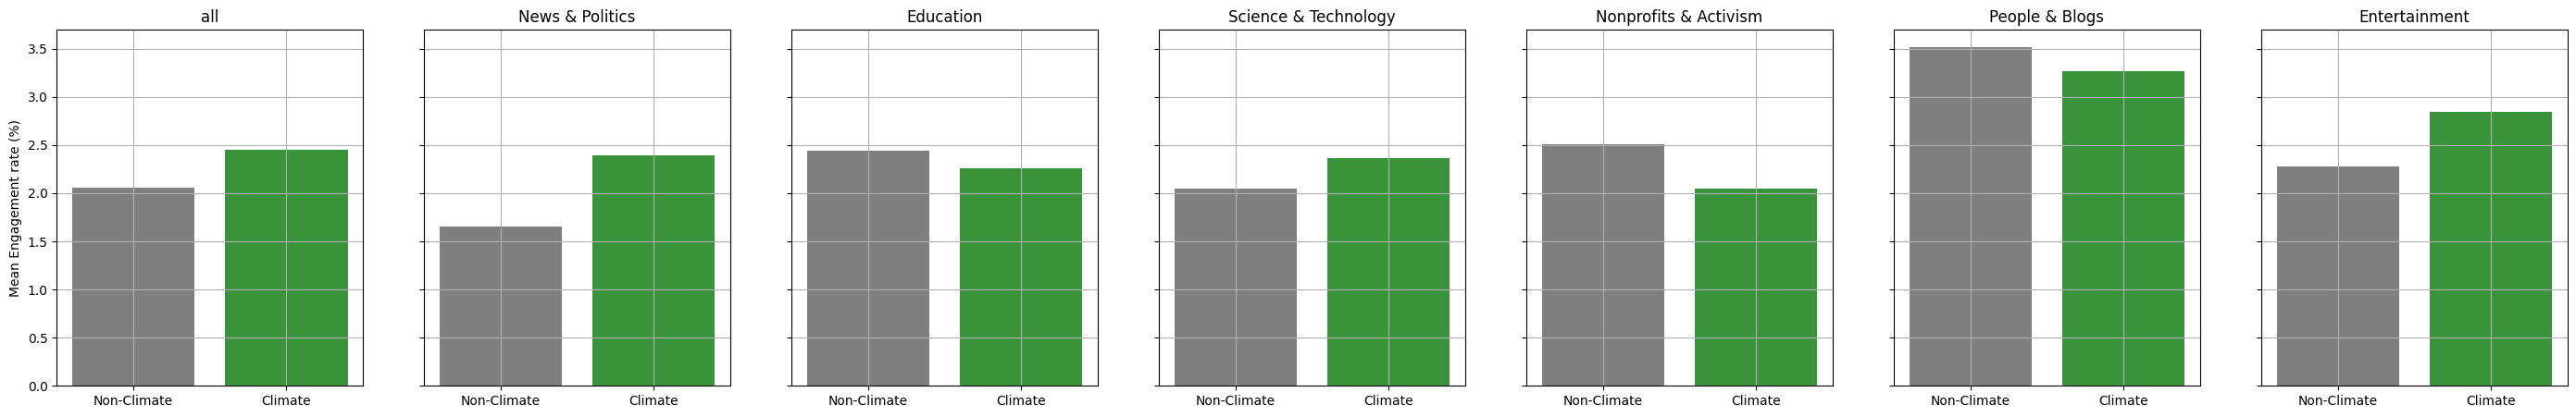

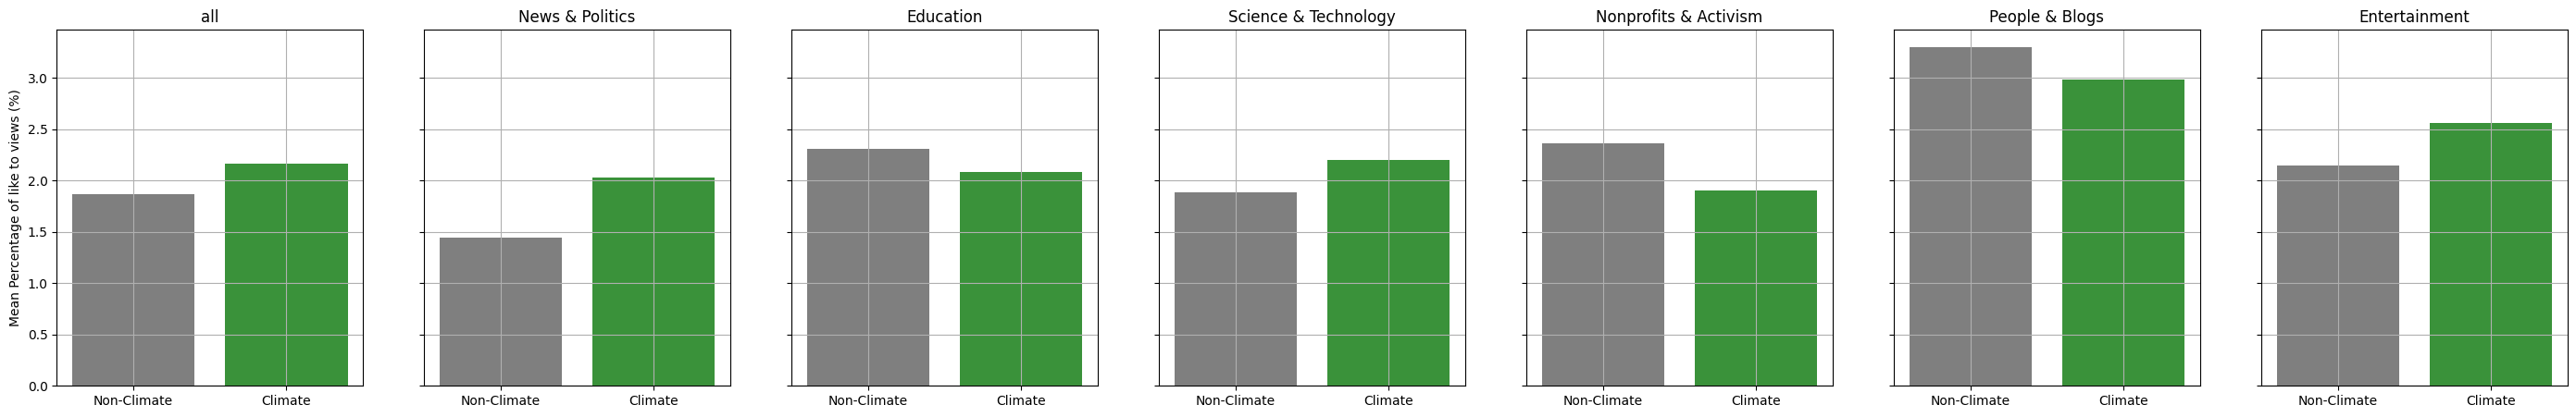

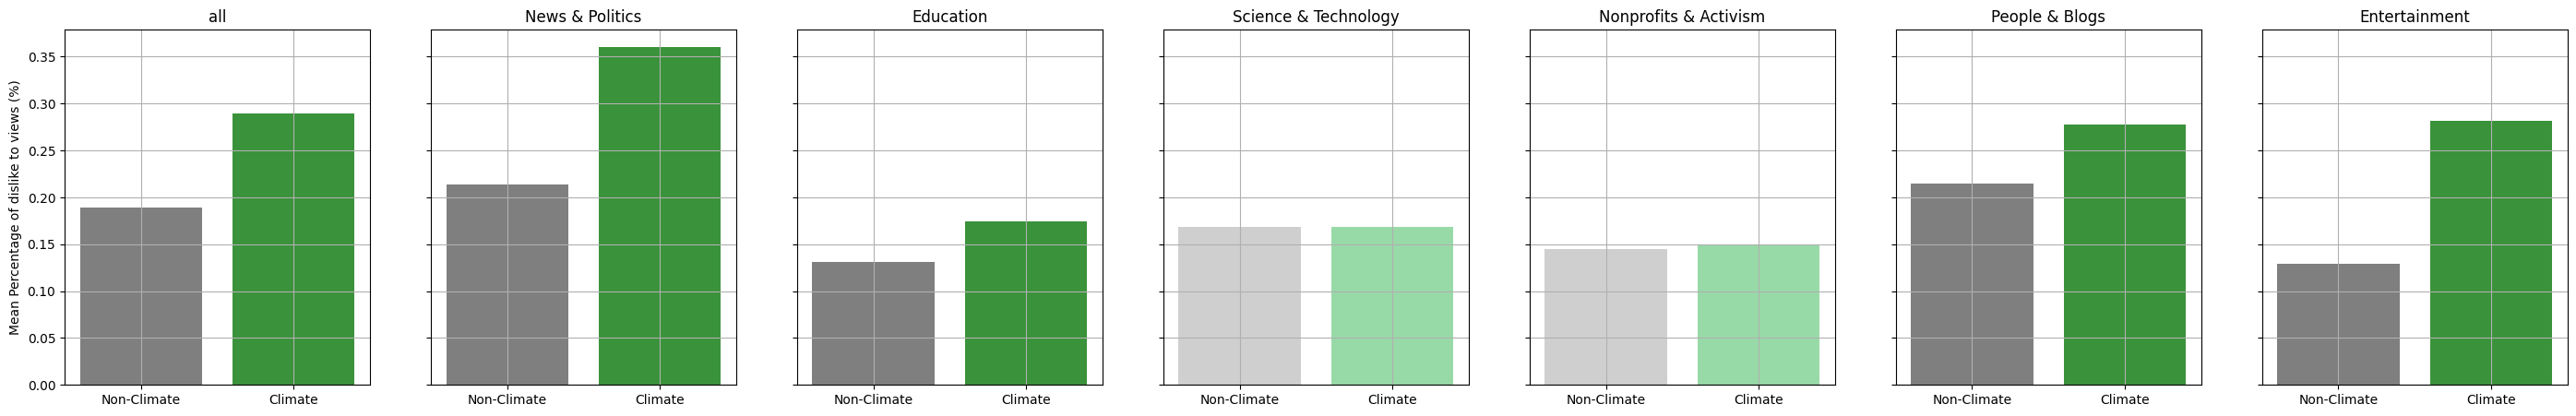

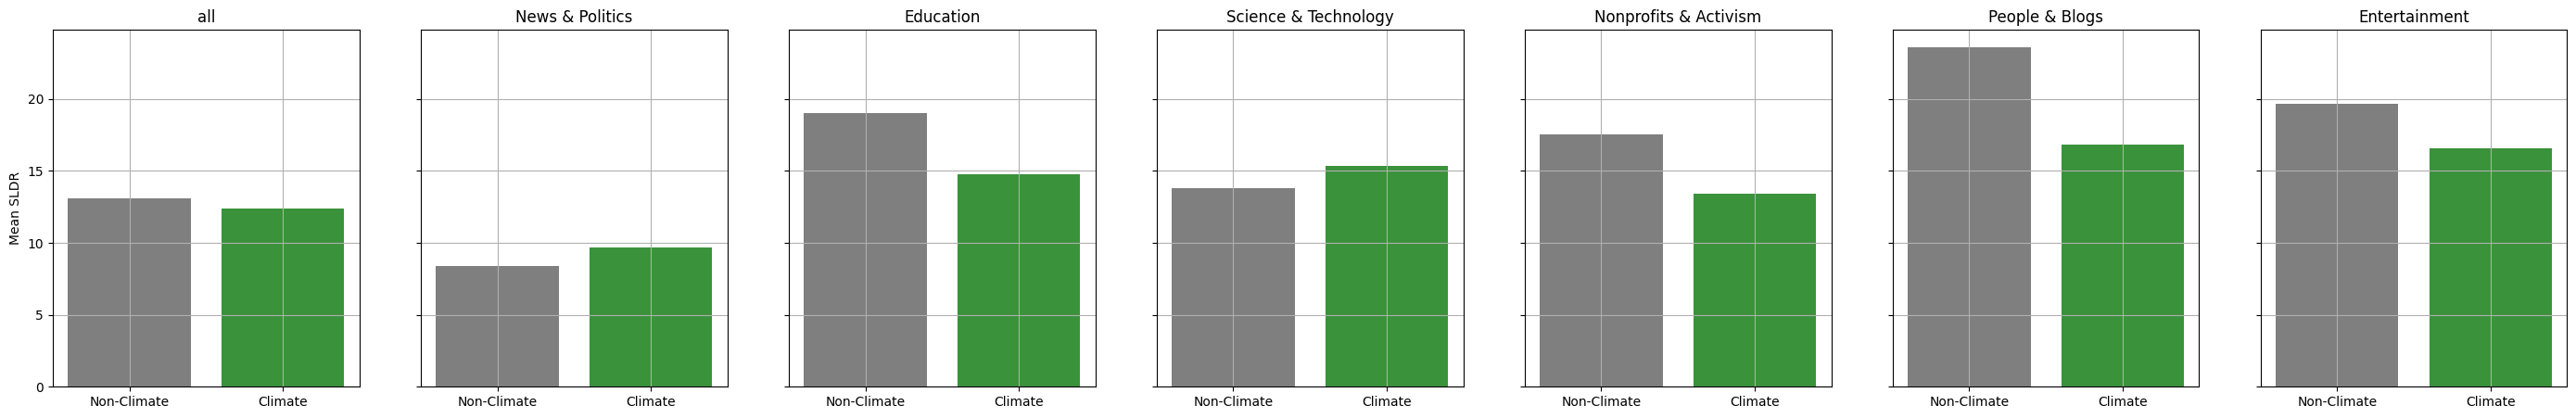

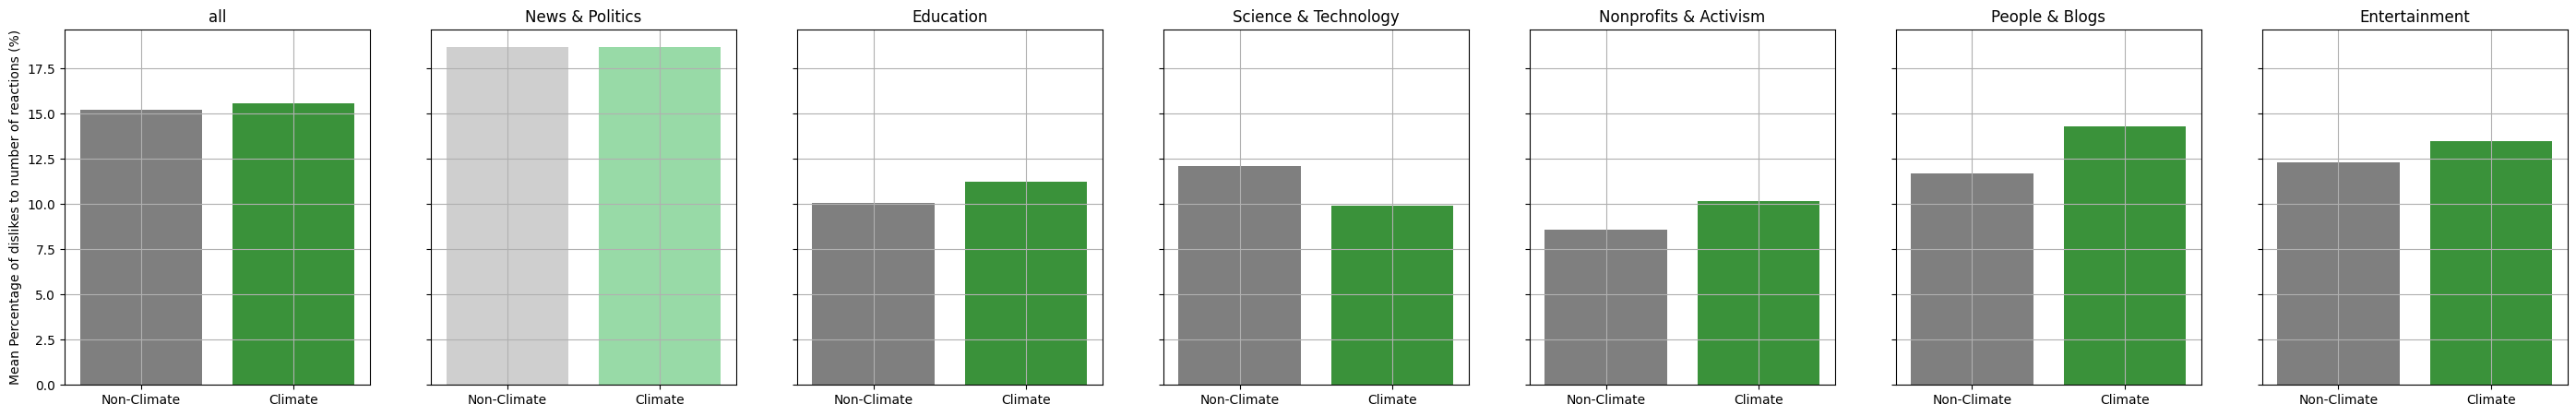

In [ ]:
labs = ['Non-Climate', 'Climate']
statistically_relevant_colors = (sns.color_palette()[7], sns.color_palette()[2])
non_statistically_relevant_colors = (sns.color_palette('pastel')[7], sns.color_palette('pastel')[2])


# Create subplots for each metric
for _, metric in enumerate(metrics):
    fig, axs = plt.subplots(1, len(regression_results_like), figsize=(5*(len(regression_results_like)),5), sharey = True)
    axs[0].set_ylabel(f'Mean {metrics_titling[metric]}')

    for idx, category in enumerate(['all'] + relevent_cat):
        # Extract data for the current category
        non_climate_metric = regression_results_like[category][metric]['intercept']
        climate_metric = regression_results_like[category][metric]['climate_intercept']
        
        if regression_results_like[category][metric]['coeff_p-value'] < 0.05:
            colors = statistically_relevent_colors
        else:
            colors = non_statistically_relevent_colors

        # Create a bar plot for the current category
        sns.barplot(
            x=labs,
            y=[non_climate_metric, climate_metric],
            palette= colors,
            ax=axs[idx]
        )
        # Set the title and labels for the current plot
        axs[idx].set_title(f'{category}')
        axs[idx].grid(True)



# Adjust layout and display the plot
plt.show()

Note: transparent colors when the analysis is not statistacally relevent (p-value > 0.05)

Being a climate change impacts all the metrics we computed. It may be a small impact, but always statitically relevent (though not category wise). 
- Climate change related are more "engaging" meaning they get more like & dislike mixed together. 
- This increase in engagment is both explained by an increase in number of likes and number of dislikes
- Being a climate change related videos decreases the SLDR and increases the dislike to number of reactions, meaning climate change realted are more debatable and "disliked" 
- Hence climate change vidoes get more dislikes. They get more likes as well but enough to totally "compensate" the dislikes

If we look categories wise,
- The augmentation in dislikes is particularly important in *Non Profit ans Activism* as well as *People and blogs*
- In both *Science & Technology* and *News and Politics* the tendecy is reversed. Climate Change rerlated videos get more likes !


### Analysis of the channels that are strongly involved with the climate change topic

In [ ]:
ch_cc_df_second.reset_index(inplace=True)
timeseries_cc_df = timeseries_df.merge(ch_cc_df_second[['name', 'channel', 'proportion_cc_vids']], how='inner', on='channel')
timeseries_cc_df['datetime'] = pd.to_datetime(timeseries_cc_df['datetime'])

We only consider channels that have more than 50% of their videos on climate change.  
We will look at when they have the most views and if it is related to climate events or not.

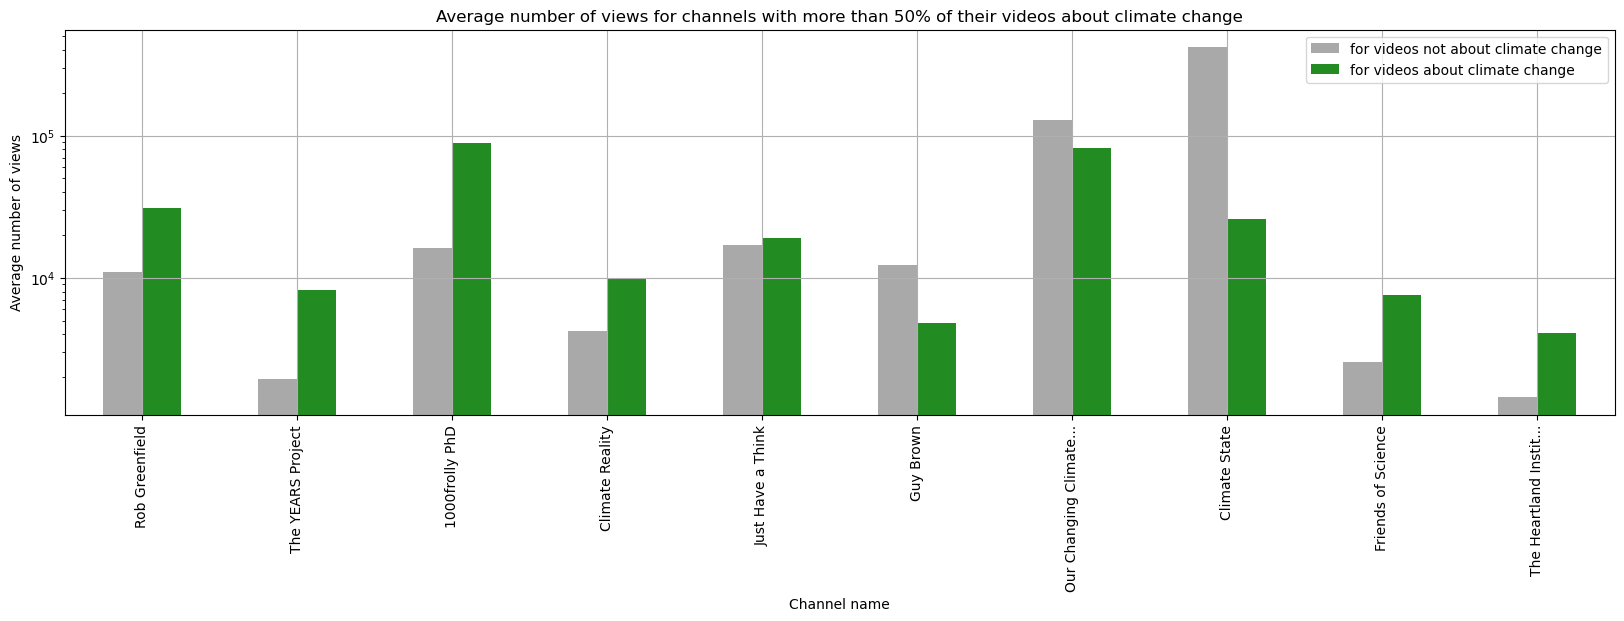

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))

ch_cc_df_second.sort_values(by='proportion_cc_vids', ascending=False, inplace=True)
ch_cc_df_second[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='bar', grid=True, ax=ax, color=[colors[0], colors[1]])

ax.set_yscale("log")
plt.title('Average number of views for channels with more than 50% of their videos about climate change')
plt.legend(['for videos not about climate change', 'for videos about climate change'], loc='upper right')
plt.ylabel('Average number of views')
plt.xlabel('Channel name')
plt.show()

In [ ]:
ch_list_second = ch_cc_df_second.channel.unique()
ch_list_df_second = [timeseries_cc_df[timeseries_cc_df['channel'] == channel].copy() for channel in ch_list_second]

colors = plt.cm.viridis(np.linspace(0, 1, len(ch_list_second)))

fig = go.Figure()

for ch, color in zip(ch_list_df_second, colors):
    ch['datetime'] = pd.to_datetime(ch['datetime'])
    ch.set_index('datetime', inplace=True)
    fig.add_trace(go.Scatter(x=ch.index, y=ch['delta_views'],
                             mode='lines',
                             name=ch['name'].iloc[0],
                             line=dict(width=2, color=f'rgba{tuple(int(255 * c) for c in color[:3])}')))

for y in range(200000, 2000000, 200000):
    for event_date in climate_events.loc['2016':'2019-10'].index:
        fig.add_trace(go.Scatter(x=[event_date, event_date], y=[0, y],
                                 mode='lines',
                                 line=dict(color='indianred', width=2),
                                 hoverinfo='text',
                                 text=f'Event: {climate_events.loc[event_date]["name"]}',
                                 showlegend=False)) 

fig.update_layout(
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value'),
    title='Time series of the channels involved in climate change',
    showlegend=True,
    legend=dict(x=1.01, y=0.5, traceorder='normal', orientation='v'),
    autosize=False,
    width=1200,
    height=600,
    margin=dict(l=5, r=0, t=50, b=5)
)

fig.show()


After some further investigations, it seems that even if some pics look like they could be related, the videos uploaded in that period of time do not have any correlation with the event in question.

In [ ]:
cch_vids_date_df = cc_vids_df[['name', 'upload_date', 'title', 'description', 'tags', 'view_count']]
display(cch_vids_date_df.loc[cch_vids_date_df['name'] == '1000frolly PhD'].sort_values(by='view_count', ascending=False)['title'].head(5))

display_id
TCy_UOjEir0       Nobel Laureate Smashes the Global Warming Hoax
SXxHfb66ZgM    Nobel Laureate in Physics; "Global Warming is ...
C35pasCr6KI    Climate Scientists Laugh at Global Warming Hys...
BiKfWdXXfIs    Freeman Dyson on the Global Warming Hysteria A...
eiPIvH49X-E    Global Warming; 31,487 Scientists say NO to Alarm
Name: title, dtype: object

Most of the videos of the channels that are involved with climate change do not make videos about specific events and when they do, it is months after the event and they usually don't have many views. Therefore, that explains why we don't observe more pronounced pics of views on those channels after a climate event.